In [2]:
import pandas as pd
from pandas import DataFrame,Series
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
%matplotlib inline

#from tensorflow.keras.initializers import normal

import os

from statsmodels.tsa.arima_model import ARIMA
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
import matplotlib.pyplot as plt 
import matplotlib.dates as dates
import matplotlib.ticker as mticker


import datetime
from datetime import datetime,timedelta
import time
from matplotlib.dates import date2num
from pandas.tseries.offsets import Day,MonthEnd
from pandas.tseries.offsets import Hour

import warnings
warnings.filterwarnings('ignore')

yf.pdr_override()

from sklearn.preprocessing import MinMaxScaler

import tensorflow.keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau

from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx


import seaborn as sns

from sklearn.decomposition import PCA

import math
from numpy.fft import *

import matplotlib.dates as dates
import matplotlib.ticker as mticker

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.metrics import accuracy_score


# Functions

In [3]:
def download(ticker,start,end,df): ## downloads the stock data from internet
    try:
        df=pdr.get_data_yahoo(ticker,start,end)
    except ValueError:
        pass
    return df

In [4]:
def to_supervised(df,n_in,n_out): ## transforms the dataframe to t-(n_in) values and adds the target in time t
    n_vars=prices.shape[1]
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    agg.dropna(inplace=True)
    df=agg
    for i in range(n_in):
        df=df.rename (columns= {"var1(t-{})".format(i+1): "Open(t-{})".format(i+1), 
                                  "var2(t-{})".format(i+1):"High(t-{})".format(i+1), 
                                  "var3(t-{})".format(i+1): "Low(t-{})".format(i+1),
                                  "var4(t-{})".format(i+1): "Close(t-{})".format(i+1),
                                  "var5(t-{})".format(i+1): "Volume(t-{})".format(i+1),
                                  #"var4(t)": "Close(t)",
                                   })
    if(n_out==1):
        df=df.rename (columns= {"var4(t)": "Close(t)"})
        df.drop(['var1(t)','var2(t)','var3(t)','var5(t)'],axis=1,inplace=True)
    else:
        df.drop(['var1(t)','var2(t)','var3(t)','var4(t)','var5(t)'],axis=1,inplace=True)
        df=df.rename (columns= {"var4(t+{})".format(n_out-1): "Close(t+{})".format(n_out-1)})
        for i in range(n_out-1):
            if((i+1)!=n_out-1):
                df.drop(['var1(t+{})'.format(i+1),'var2(t+{})'.format(i+1),'var3(t+{})'.format(i+1),
                        'var4(t+{})'.format(i+1),'var5(t+{})'.format(i+1)],axis=1,inplace=True)
            else:
                df.drop(['var1(t+{})'.format(i+1),'var2(t+{})'.format(i+1),'var3(t+{})'.format(i+1),
                        'var5(t+{})'.format(i+1)],axis=1,inplace=True)
                
    return df

In [5]:
def transform_features(df):
    # reshape input to be [samples, time steps, features]
    #passing data as features
    
    df['GS_Close']=df['GS_Close(t)']
    df.drop(['GS_Close(t)'],axis=1,inplace=True)    
    
    df=np.array(df)
    x_train=df[:len(df)-365,:-1]
    y_train=df[:len(df)-365,-1]

    Xtest=df[len(df)-365:,:-1]
    ytest=df[len(df)-365:,-1]

    y_train=y_train.reshape(-1,1)
    ytest=ytest.reshape(-1,1)

    scaler_x = MinMaxScaler()
    scaler_x.fit(x_train)
    x_train=scaler_x.transform(x_train)
    Xtest=scaler_x.transform(Xtest)

    scaler_y = MinMaxScaler()
    scaler_y.fit(y_train)
    y_train=scaler_y.transform(y_train)
    ytest=scaler_y.transform(ytest)

    x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
    Xtest = Xtest.reshape((Xtest.shape[0], 1, Xtest.shape[1]))
    
    return(x_train,y_train,Xtest,ytest,scaler_x,scaler_y)

In [6]:
def transform_timesteps(df):
    # reshape input to be [samples, time steps, features]
    #passing data as timesteps
    
    df['GS_Close']=df['GS_Close(t)']
    df.drop(['GS_Close(t)'],axis=1,inplace=True)

    df=np.array(df)
    x_train=df[:len(df)-365,:-1]
    y_train=df[:len(df)-365,-1]

    Xtest=df[len(df)-365:,:-1]
    ytest=df[len(df)-365:,-1]

    y_train=y_train.reshape(-1,1)
    ytest=ytest.reshape(-1,1)

    scaler_x = MinMaxScaler()
    scaler_x.fit(x_train)
    x_train=scaler_x.transform(x_train)
    Xtest=scaler_x.transform(Xtest)

    scaler_y = MinMaxScaler()
    scaler_y.fit(y_train)
    y_train=scaler_y.transform(y_train)
    ytest=scaler_y.transform(ytest)


    x_train = x_train.reshape((x_train.shape[0],x_train.shape[1],1))
    Xtest = Xtest.reshape((Xtest.shape[0],Xtest.shape[1],1))
    return(x_train,y_train,Xtest,ytest,scaler_x,scaler_y)

In [7]:
def MSE(actual,prediction):## Mean squared error function
    return np.sum((actual-prediction)**2)/len(actual)

In [8]:
def gainz(prediction,actual,use):
    ## custom metric.It assumes you trade daily without stop losses or targets.At open you buy or sell according to
    ## the prediction we made for this day and the change of price between the prediction and the previous day and you close the
    ## position at the close of the market
    change=use.pct_change().dropna()
    predict_change=pd.DataFrame(np.append(use[694],prediction)).pct_change().dropna()
    gainz=[]
    for i,j,ac,pred,to_use in zip(predict_change[0],change,actual,np.reshape(prediction,(365)),use[:-1]):
        if (np.sign(i)!=np.sign(j)):
            loss=np.abs(to_use-ac)
            gainz.append(-loss)
        if(np.sign(i)==np.sign(j)):
            gain=np.abs(ac-to_use)
            gainz.append(gain)
        
    return gainz

In [9]:
prices=pd.read_csv("all_stocks/GS.csv")
n_in=1
n_out=1
date = prices['Date']
prices.drop(['Date'],axis=1,inplace=True)
prices=to_supervised(prices,n_in,n_out)
names=[]
for i in prices.columns:
    names.append('GS_{}'.format(i))
prices.columns=names
prices['Date'] = date
prices.head()

GS_Open(t-1)  GS_High(t-1)  GS_Low(t-1)  GS_Close(t-1)  GS_Volume(t-1)  \
1    196.649994    196.830002   193.770004     193.830002       1566800.0   
2    195.300003    195.729996   192.699997     194.410004       1877700.0   
3    193.059998    194.039993   187.479996     188.339996       3413200.0   
4    188.300003    188.660004   183.929993     184.529999       3429200.0   
5    186.850006    187.990005   185.770004     187.279999       1896800.0   

   GS_Close(t)        Date  
1   194.410004  2015-01-02  
2   188.339996  2015-01-05  
3   184.529999  2015-01-06  
4   187.279999  2015-01-07  
5   190.270004  2015-01-08

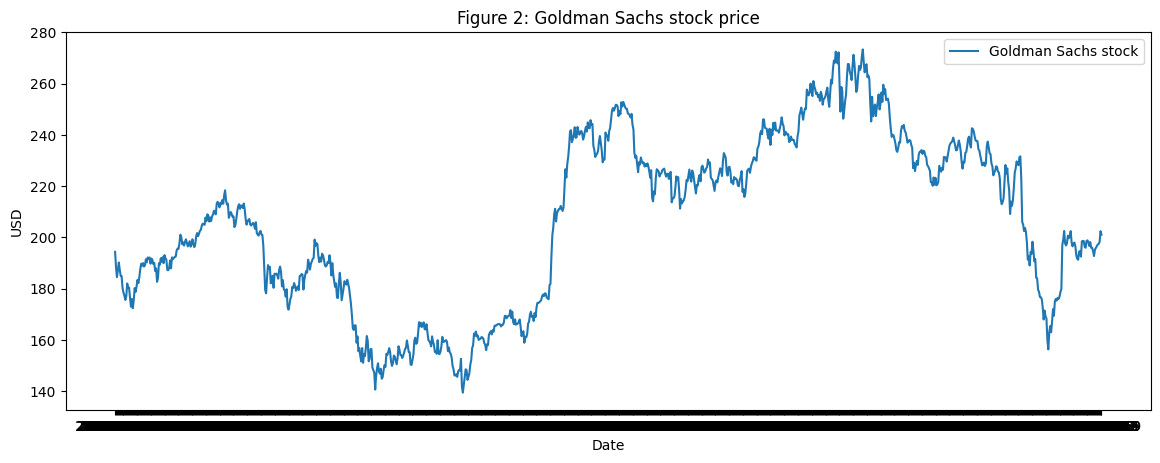

In [10]:
import datetime

plt.figure(figsize=(14, 5), dpi=100)
plt.plot(prices['Date'], prices['GS_Close(t)'], label='Goldman Sachs stock')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Figure 2: Goldman Sachs stock price')
plt.legend()
plt.show()

# LSTM networks with features only from the stock(OHLC & VOLUME) 

### Simple LSTM & passing data as features

In [11]:
Xtrain_f,ytrain_f,Xtest_f,ytest_f,scaler_x_f,scaler_y_f=transform_features(prices)

model_lstm = tensorflow.keras.models.Sequential()
model_lstm.add(layers.LSTM(50, input_shape=(Xtrain_f.shape[1], Xtrain_f.shape[2])))
model_lstm.add(layers.Dense(1))
opt=tensorflow.keras.optimizers.Adam(lr=0.01,epsilon=None,decay=0)
model_lstm.compile(loss='mse', optimizer=opt)

earlyStopping =EarlyStopping(monitor='val_loss', patience=50, verbose=0, mode='min')
mcp_save = ModelCheckpoint('simple_lstm_1.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1,min_delta=0.01, mode='min')

model_lstm.fit(Xtrain_f,ytrain_f, epochs=60, batch_size=20, validation_data=(Xtest_f,ytest_f),verbose=1,callbacks=[earlyStopping, mcp_save, reduce_lr_loss])

trainPredict_f=model_lstm.predict(Xtrain_f)
testPredict_f= model_lstm.predict(Xtest_f)

all_predictions_f=[]
trainPredict_f=scaler_y_f.inverse_transform(trainPredict_f)
testPredict_f=scaler_y_f.inverse_transform(testPredict_f)
all_predictions_f=np.append(trainPredict_f,testPredict_f)

ValueError: could not convert string to float: '2015-01-02'

Text(0.5, 1.0, 'Gain=39.68002599999983')

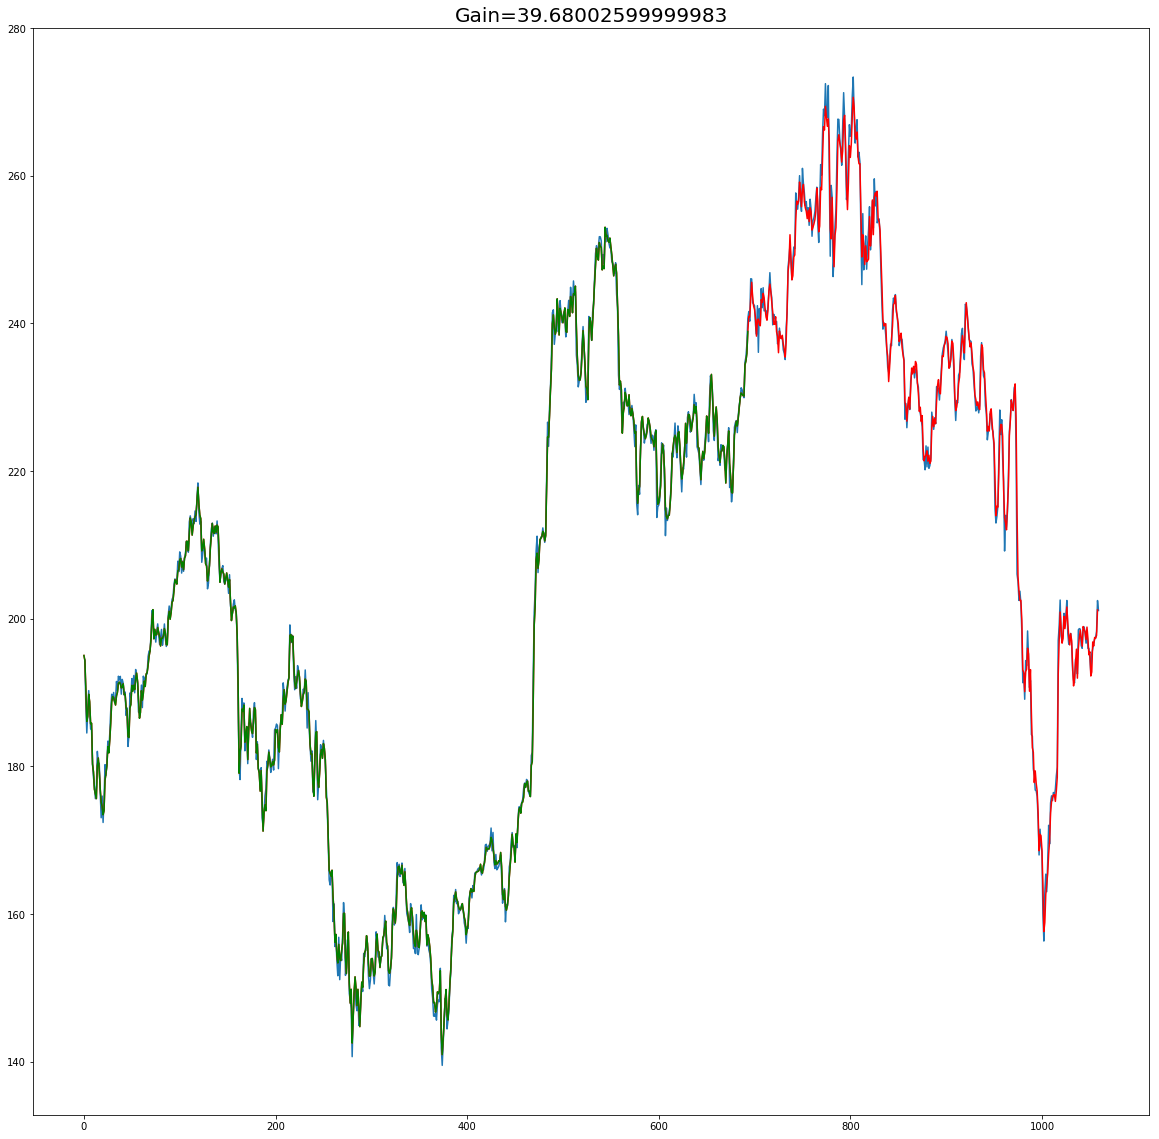

In [ ]:
prices=prices.rename(columns={'GS_Close':'GS_Close(t)'})
actual=prices["GS_Close(t)"][len(prices)-len(Xtest_f):]
use=prices["GS_Close(t)"][len(prices)-len(Xtest_f)-1:]

plt.figure(figsize=(20,20))
plt.plot(prices['GS_Close(t)'])

plt.plot(all_predictions_f,'r')
plt.plot(trainPredict_f,'g')
plt.title('Gain={}'.format(np.sum(gainz(testPredict_f,actual,use))),size=20)

### Simple LSTM & passing data as timesteps

In [ ]:
Xtrain_t,ytrain_t,Xtest_t,ytest_t,scaler_x_t,scaler_y_t=transform_timesteps(prices)


model_lstm = tensorflow.keras.models.Sequential()
model_lstm.add(layers.LSTM(80, input_shape=(Xtrain_t.shape[1], Xtrain_t.shape[2])))
model_lstm.add(layers.Dense(1))
opt=tensorflow.keras.optimizers.Adam(lr=0.01,epsilon=None,decay=0)
model_lstm.compile(loss='mse', optimizer=opt)

earlyStopping =EarlyStopping(monitor='val_loss', patience=50, verbose=0, mode='min')
mcp_save = ModelCheckpoint('simple_lstm_2.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1,min_delta=0.01, mode='min')

model_lstm.fit(Xtrain_t,ytrain_t, epochs=60, batch_size=20, validation_data=(Xtest_t, ytest_t),verbose=1,callbacks=[earlyStopping, mcp_save, reduce_lr_loss])

trainPredict_t=model_lstm.predict(Xtrain_t)
testPredict_t= model_lstm.predict(Xtest_t)

all_predictions_t=[]
trainPredict_t=scaler_y_t.inverse_transform(trainPredict_t)
testPredict_t=scaler_y_t.inverse_transform(testPredict_t)
all_predictions_t=np.append(trainPredict_t,testPredict_t)

Train on 694 samples, validate on 365 samples
Epoch 1/60
694/694 [==============================] - 17s 25ms/step - loss: 0.0219 - val_loss: 0.0037
Epoch 2/60
694/694 [==============================] - 1s 1ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 3/60
694/694 [==============================] - 1s 1ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 4/60
694/694 [==============================] - 1s 1ms/step - loss: 9.1329e-04 - val_loss: 0.0014
Epoch 5/60
694/694 [==============================] - 1s 1ms/step - loss: 9.9619e-04 - val_loss: 0.0019
Epoch 6/60
694/694 [==============================] - 1s 949us/step - loss: 0.0011 - val_loss: 0.0022
Epoch 7/60
694/694 [==============================] - 1s 959us/step - loss: 8.6384e-04 - val_loss: 0.0014
Epoch 8/60
660/694 [===========================>..] - ETA: 0s - loss: 0.0011 
Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
694/694 [==============================] - 4s 6ms/step - loss: 0.0011 - val_lo

Text(0.5, 1.0, 'Gain=39.68002599999983')

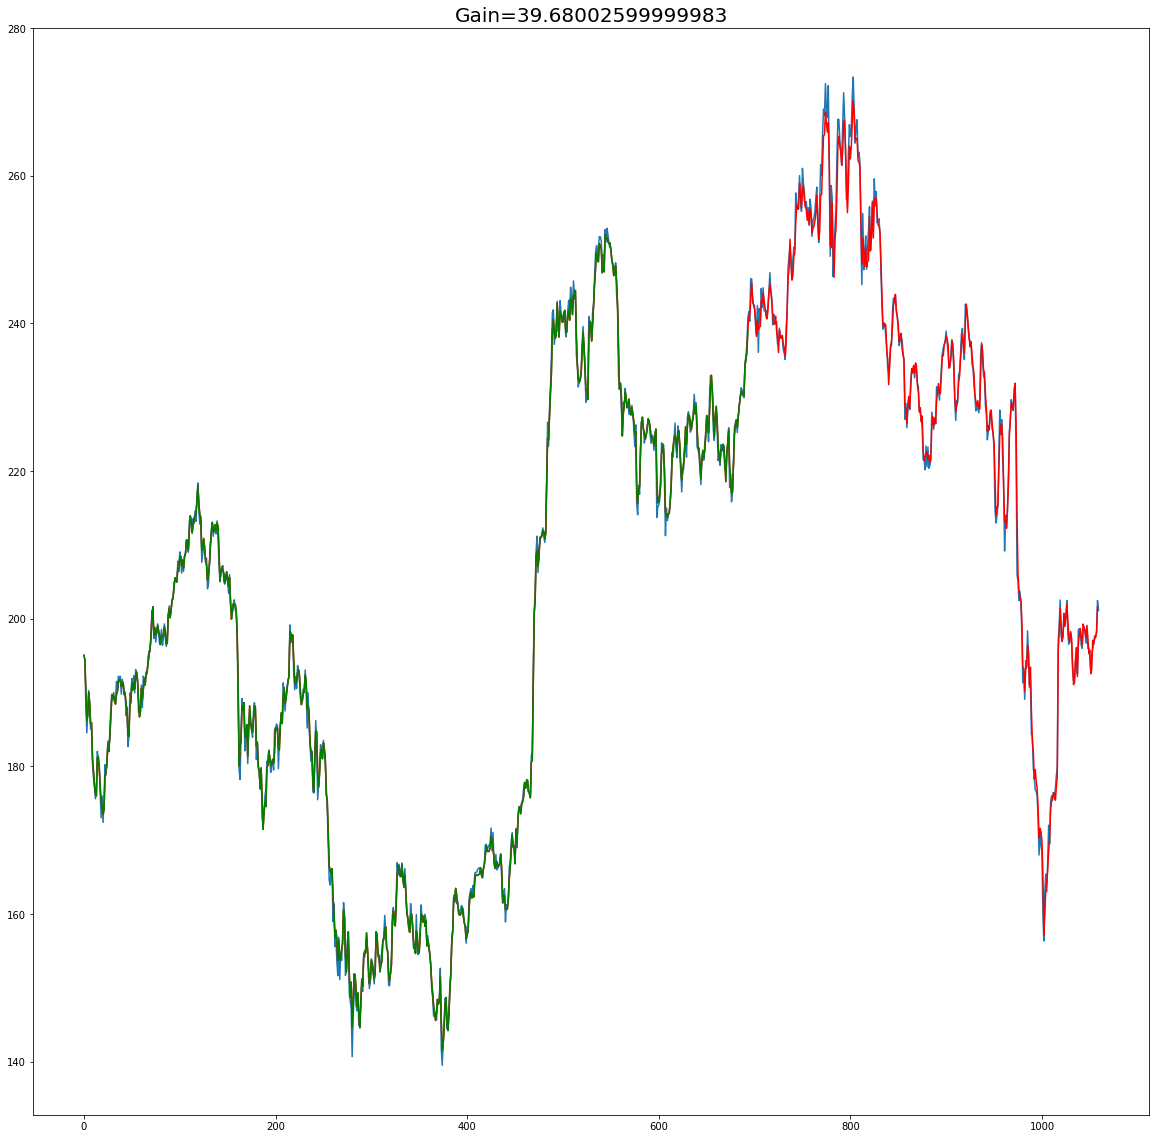

In [ ]:
prices=prices.rename(columns={'GS_Close':'GS_Close(t)'})

actual=prices["GS_Close(t)"][len(prices)-len(Xtest_t):]
use=prices["GS_Close(t)"][len(prices)-len(Xtest_t)-1:]

plt.figure(figsize=(20,20))
plt.plot(prices['GS_Close(t)'])

plt.plot(all_predictions_t,'r')
plt.plot(trainPredict_t,'g')
plt.title('Gain={}'.format(np.sum(gainz(testPredict_f,actual,use))),size=20)

### Simple LSTM with memory between batches

In [ ]:
Xtrain_f,ytrain_f,Xtest_f,ytest_f,scaler_x_f,scaler_y_f=transform_features(prices)

model_lstm = tensorflow.keras.models.Sequential()
model_lstm.add(layers.LSTM(50, input_shape=(Xtrain_f.shape[1], Xtrain_f.shape[2])))
model_lstm.add(layers.Dense(1))
opt=tensorflow.keras.optimizers.Adam(lr=0.001,epsilon=None,decay=0)
model_lstm.compile(loss='mse', optimizer=opt)
for i in range(50):
    model_lstm.fit(Xtrain_f,ytrain_f, epochs=1, batch_size=20, validation_data=(Xtest_f,ytest_f),verbose=1,shuffle=False)
    model_lstm.reset_states()
    
trainPredict_mem=model_lstm.predict(Xtrain_f)
model_lstm.reset_states()
testPredict_mem= model_lstm.predict(Xtest_f)

all_predictions_mem=[]
trainPredict_mem=scaler_y_f.inverse_transform(trainPredict_mem)
testPredict_mem=scaler_y_f.inverse_transform(testPredict_mem)
all_predictions_mem=np.append(trainPredict_mem,testPredict_mem)

Train on 694 samples, validate on 365 samples
Epoch 1/1
694/694 [==============================] - 10s 14ms/step - loss: 0.1410 - val_loss: 0.1669
Train on 694 samples, validate on 365 samples
Epoch 1/1
694/694 [==============================] - 0s 214us/step - loss: 0.0198 - val_loss: 0.0183
Train on 694 samples, validate on 365 samples
Epoch 1/1
694/694 [==============================] - 0s 210us/step - loss: 0.0084 - val_loss: 0.0066
Train on 694 samples, validate on 365 samples
Epoch 1/1
694/694 [==============================] - 0s 207us/step - loss: 0.0071 - val_loss: 0.0056
Train on 694 samples, validate on 365 samples
Epoch 1/1
694/694 [==============================] - 0s 203us/step - loss: 0.0052 - val_loss: 0.0038
Train on 694 samples, validate on 365 samples
Epoch 1/1
694/694 [==============================] - 0s 200us/step - loss: 0.0038 - val_loss: 0.0026
Train on 694 samples, validate on 365 samples
Epoch 1/1
694/694 [==============================] - 0s 197us/step - los

Text(0.5, 1.0, 'Gain=48.600039999999865')

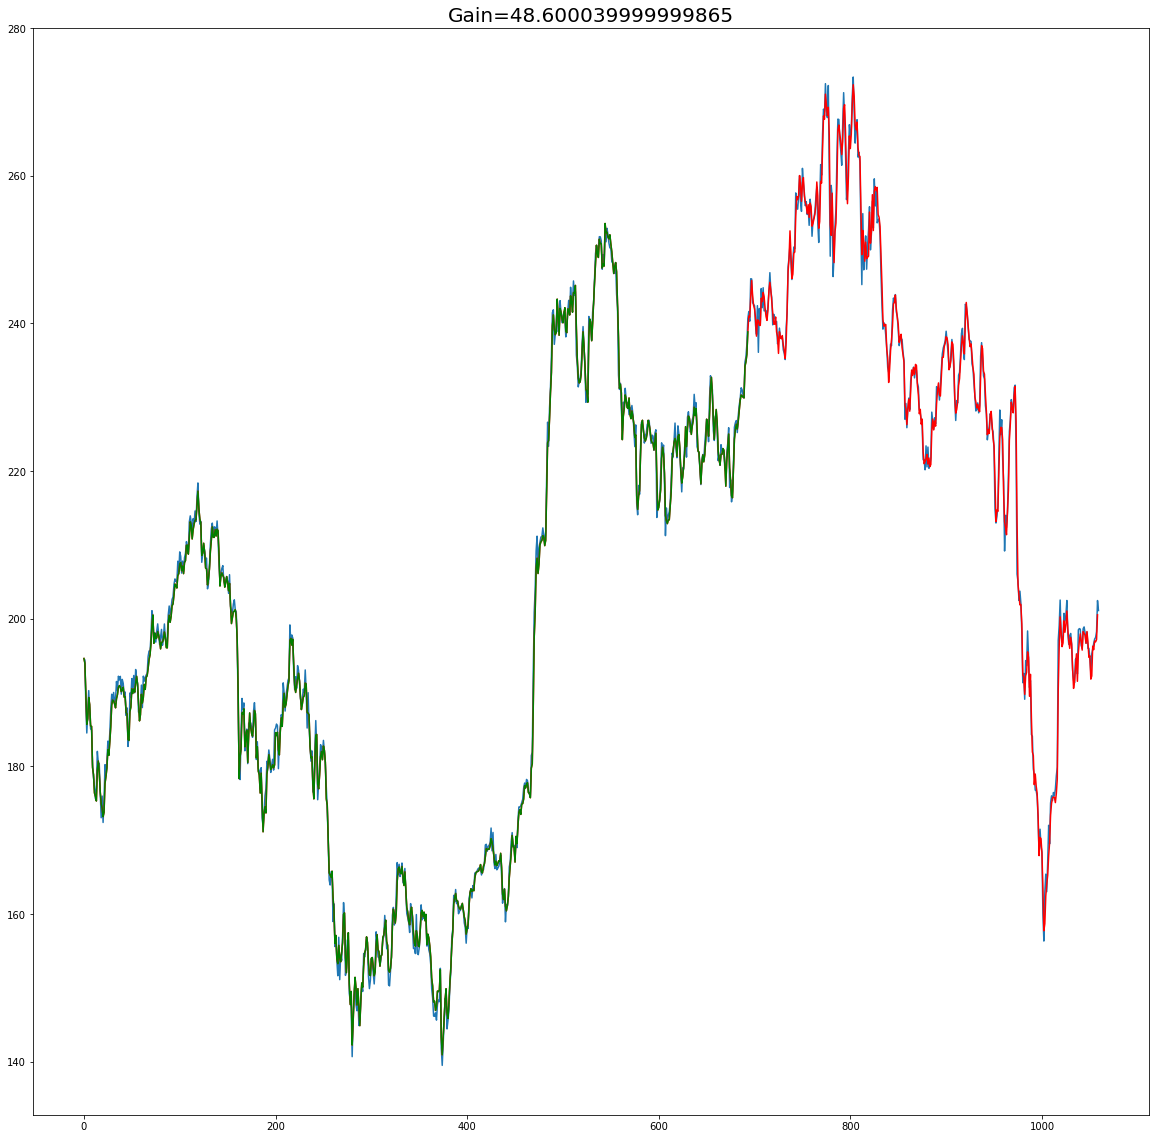

In [ ]:
prices=prices.rename(columns={'GS_Close':'GS_Close(t)'})

actual=prices["GS_Close(t)"][len(prices)-len(Xtest_f):]
use=prices["GS_Close(t)"][len(prices)-len(Xtest_f)-1:]

plt.figure(figsize=(20,20))
plt.plot(prices['GS_Close(t)'])

plt.plot(all_predictions_mem,'r')
plt.plot(trainPredict_mem,'g')
plt.title('Gain={}'.format(np.sum(gainz(testPredict_mem,actual,use))),size=20)

### Adding Dropout

In [ ]:
Xtrain_f,ytrain_f,Xtest_f,ytest_f,scaler_x_f,scaler_y_f=transform_features(prices)

model_lstm = tensorflow.keras.models.Sequential()
model_lstm.add(layers.LSTM(50, input_shape=(Xtrain_f.shape[1], Xtrain_f.shape[2])))
model_lstm.add(layers.Dropout(0.2))
model_lstm.add(layers.Dense(1))
opt=tensorflow.keras.optimizers.Adam(lr=0.001,epsilon=None,decay=0)
model_lstm.compile(loss='mse', optimizer=opt)
for i in range(50):
    model_lstm.fit(Xtrain_f,ytrain_f, epochs=1, batch_size=20, validation_data=(Xtest_f,ytest_f),verbose=1,shuffle=False)
    model_lstm.reset_states()
    
trainPredict_mem=model_lstm.predict(Xtrain_f)
model_lstm.reset_states()
testPredict_mem= model_lstm.predict(Xtest_f)

all_predictions_mem=[]
trainPredict_mem=scaler_y_f.inverse_transform(trainPredict_mem)
testPredict_mem=scaler_y_f.inverse_transform(testPredict_mem)
all_predictions_mem=np.append(trainPredict_mem,testPredict_mem)

Train on 694 samples, validate on 365 samples
Epoch 1/1
694/694 [==============================] - 10s 14ms/step - loss: 0.1295 - val_loss: 0.1318
Train on 694 samples, validate on 365 samples
Epoch 1/1
694/694 [==============================] - 0s 208us/step - loss: 0.0153 - val_loss: 0.0111
Train on 694 samples, validate on 365 samples
Epoch 1/1
694/694 [==============================] - 0s 217us/step - loss: 0.0094 - val_loss: 0.0055
Train on 694 samples, validate on 365 samples
Epoch 1/1
694/694 [==============================] - 0s 208us/step - loss: 0.0075 - val_loss: 0.0047
Train on 694 samples, validate on 365 samples
Epoch 1/1
694/694 [==============================] - 0s 206us/step - loss: 0.0065 - val_loss: 0.0030
Train on 694 samples, validate on 365 samples
Epoch 1/1
694/694 [==============================] - 0s 200us/step - loss: 0.0050 - val_loss: 0.0022
Train on 694 samples, validate on 365 samples
Epoch 1/1
694/694 [==============================] - 0s 187us/step - los

Text(0.5, 1.0, 'Gain=71.17999799999984')

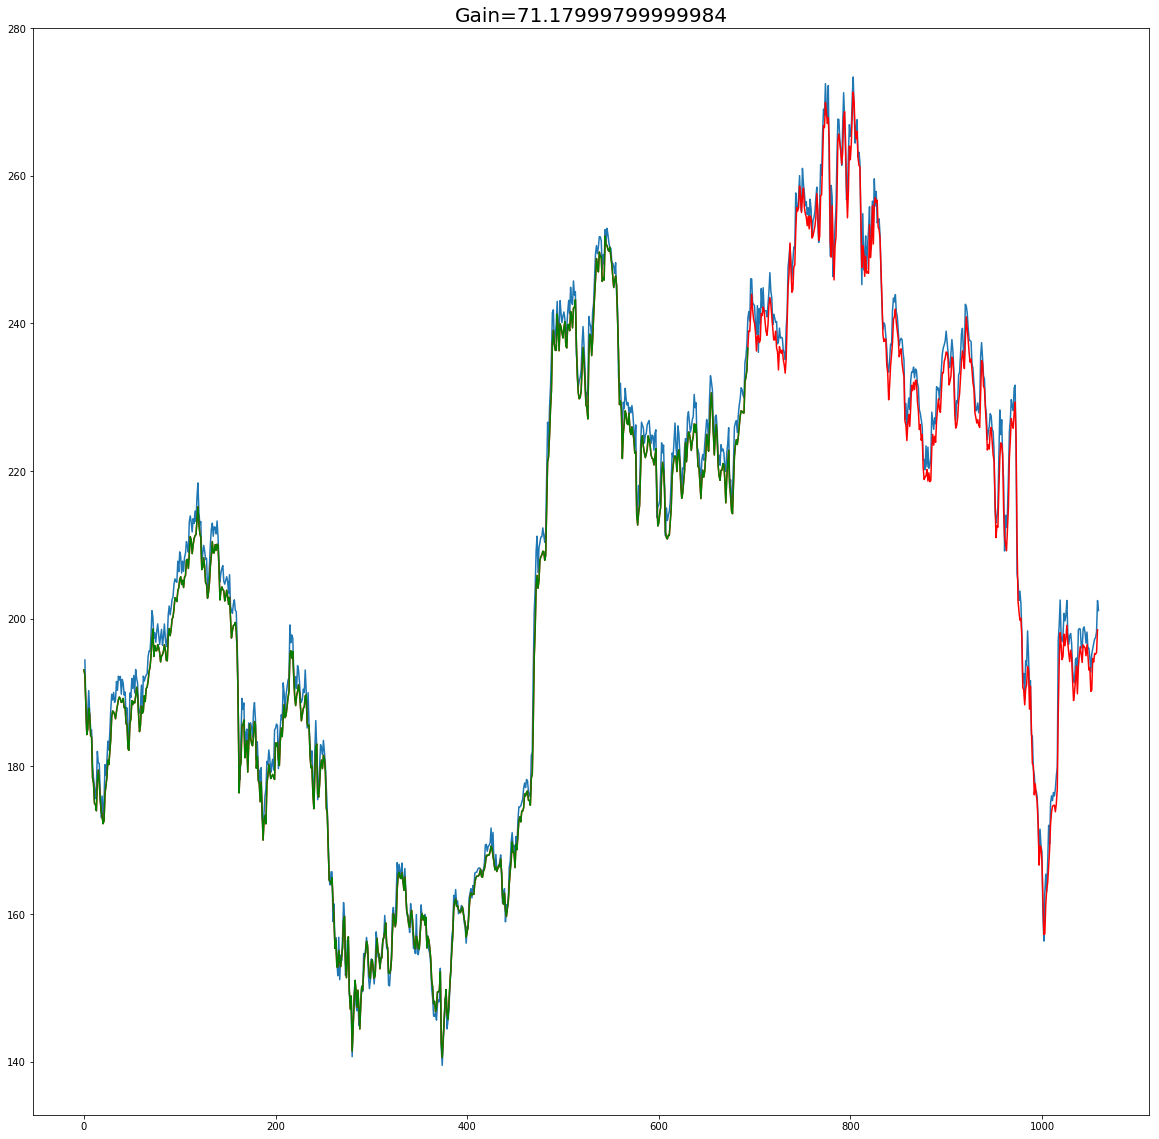

In [ ]:
prices=prices.rename(columns={'GS_Close':'GS_Close(t)'})

actual=prices["GS_Close(t)"][len(prices)-len(Xtest_f):]
use=prices["GS_Close(t)"][len(prices)-len(Xtest_f)-1:]

plt.figure(figsize=(20,20))
plt.plot(prices['GS_Close(t)'])

plt.plot(all_predictions_mem,'r')
plt.plot(trainPredict_mem,'g')
plt.title('Gain={}'.format(np.sum(gainz(testPredict_mem,actual,use))),size=20)

# Stacked LSTMS

### LSTM & passing data as features

In [ ]:
Xtrain_f,ytrain_f,Xtest_f,ytest_f,scaler_x_f,scaler_y_f=transform_features(prices)

model_lstm = tensorflow.keras.models.Sequential()
model_lstm.add(layers.LSTM(50, input_shape=(Xtrain_f.shape[1], Xtrain_f.shape[2]),return_sequences=True))
model_lstm.add(layers.LSTM(30, input_shape=(Xtrain_f.shape[1], Xtrain_f.shape[2])))
model_lstm.add(layers.Dense(1))
opt=tensorflow.keras.optimizers.Adam(lr=0.01,epsilon=None,decay=0)
model_lstm.compile(loss='mse', optimizer=opt)
earlyStopping =EarlyStopping(monitor='val_loss', patience=50, verbose=0, mode='min')
mcp_save = ModelCheckpoint('simple_lstm_3.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=70, verbose=1,min_delta=0.00001, mode='min')

model_lstm.fit(Xtrain_f,ytrain_f, epochs=150, batch_size=20, validation_data=(Xtest_f, ytest_f),verbose=1,callbacks=[earlyStopping, mcp_save, reduce_lr_loss])

trainPredict_f=model_lstm.predict(Xtrain_f)
testPredict_f= model_lstm.predict(Xtest_f)

all_predictions_f=[]
trainPredict_f=scaler_y_f.inverse_transform(trainPredict_f)
testPredict_f=scaler_y_f.inverse_transform(testPredict_f)
all_predictions_f=np.append(trainPredict_f,testPredict_f)


Train on 694 samples, validate on 365 samples
Epoch 1/150
694/694 [==============================] - 20s 28ms/step - loss: 0.0497 - val_loss: 0.0080
Epoch 2/150
694/694 [==============================] - 0s 467us/step - loss: 0.0014 - val_loss: 0.0017
Epoch 3/150
694/694 [==============================] - 0s 434us/step - loss: 8.5488e-04 - val_loss: 0.0012
Epoch 4/150
694/694 [==============================] - 0s 269us/step - loss: 7.3908e-04 - val_loss: 0.0013
Epoch 5/150
694/694 [==============================] - 0s 269us/step - loss: 7.7882e-04 - val_loss: 0.0014
Epoch 6/150
694/694 [==============================] - 0s 247us/step - loss: 7.4440e-04 - val_loss: 0.0013
Epoch 7/150
694/694 [==============================] - 0s 253us/step - loss: 7.2254e-04 - val_loss: 0.0012
Epoch 8/150
694/694 [==============================] - 0s 246us/step - loss: 7.4351e-04 - val_loss: 0.0012
Epoch 9/150
694/694 [==============================] - 0s 249us/step - loss: 7.4013e-04 - val_loss: 0.0013

Text(0.5, 1.0, 'Gain=16.77998000000025')

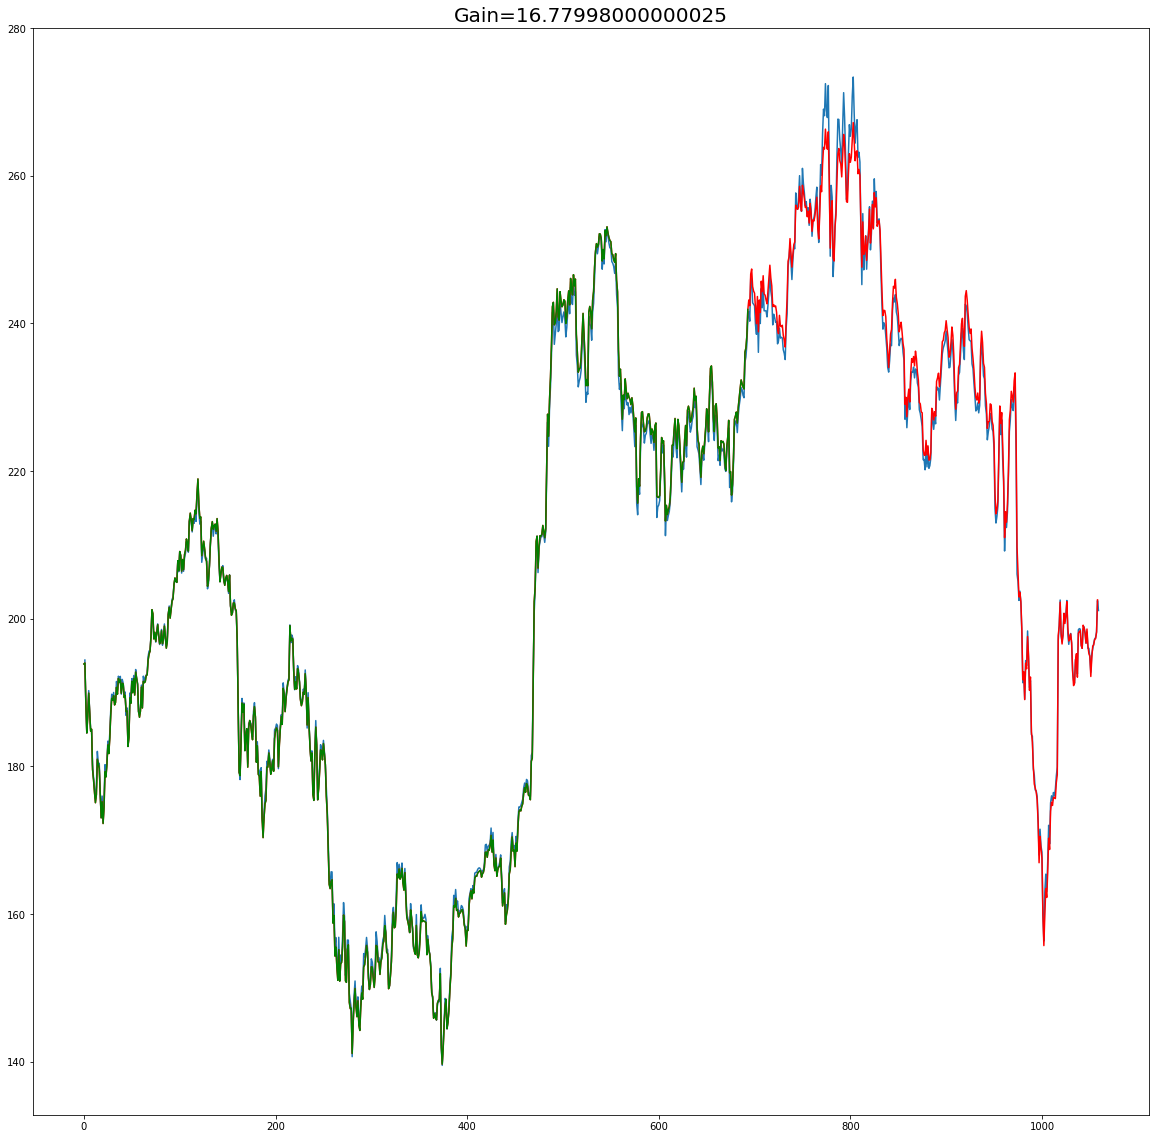

In [ ]:
prices=prices.rename(columns={'GS_Close':'GS_Close(t)'})
actual=prices["GS_Close(t)"][len(prices)-len(Xtest_f):]
use=prices["GS_Close(t)"][len(prices)-len(Xtest_f)-1:]

plt.figure(figsize=(20,20))
plt.plot(prices['GS_Close(t)'])

plt.plot(all_predictions_f,'r')
plt.plot(trainPredict_f,'g')
plt.title('Gain={}'.format(np.sum(gainz(testPredict_f,actual,use))),size=20)

### LSTM & Passing data as timesteps

In [ ]:
Xtrain_t,ytrain_t,Xtest_t,ytest_t,scaler_x_t,scaler_y_t=transform_features(prices)

model_lstm = tensorflow.keras.models.Sequential()
model_lstm.add(layers.LSTM(50, input_shape=(Xtrain_t.shape[1], Xtrain_t.shape[2]),return_sequences=True))
model_lstm.add(layers.LSTM(30, input_shape=(Xtrain_t.shape[1], Xtrain_t.shape[2])))
model_lstm.add(layers.Dense(1))
opt=tensorflow.keras.optimizers.Adam(lr=0.01,epsilon=None,decay=0)
model_lstm.compile(loss='mse', optimizer=opt)
earlyStopping =EarlyStopping(monitor='val_loss', patience=50, verbose=0, mode='min')
mcp_save = ModelCheckpoint('simple_lstm_4.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=70, verbose=1,min_delta=0.00001, mode='min')

model_lstm.fit(Xtrain_t,ytrain_t, epochs=150, batch_size=20, validation_data=(Xtest_t, ytest_t),verbose=1,callbacks=[earlyStopping, mcp_save, reduce_lr_loss])

trainPredict_t=model_lstm.predict(Xtrain_t)
testPredict_t= model_lstm.predict(Xtest_t)

all_predictions_t=[]
trainPredict_t=scaler_y_t.inverse_transform(trainPredict_t)
testPredict_t=scaler_y_t.inverse_transform(testPredict_t)
all_predictions_t=np.append(trainPredict_t,testPredict_t)


Train on 694 samples, validate on 365 samples
Epoch 1/150
694/694 [==============================] - 19s 27ms/step - loss: 0.0511 - val_loss: 0.0130
Epoch 2/150
694/694 [==============================] - 0s 470us/step - loss: 0.0018 - val_loss: 0.0013
Epoch 3/150
694/694 [==============================] - 0s 601us/step - loss: 7.9498e-04 - val_loss: 0.0013
Epoch 4/150
694/694 [==============================] - 0s 381us/step - loss: 7.6844e-04 - val_loss: 0.0013
Epoch 5/150
694/694 [==============================] - 0s 476us/step - loss: 7.5152e-04 - val_loss: 0.0012
Epoch 6/150
694/694 [==============================] - 0s 274us/step - loss: 8.1158e-04 - val_loss: 0.0017
Epoch 7/150
694/694 [==============================] - 0s 269us/step - loss: 7.9089e-04 - val_loss: 0.0013
Epoch 8/150
694/694 [==============================] - 0s 262us/step - loss: 7.6018e-04 - val_loss: 0.0013
Epoch 9/150
694/694 [==============================] - 0s 255us/step - loss: 7.3934e-04 - val_loss: 0.0013

Epoch 77/150
694/694 [==============================] - 0s 249us/step - loss: 8.6711e-04 - val_loss: 0.0011
Epoch 78/150
694/694 [==============================] - 0s 243us/step - loss: 7.4880e-04 - val_loss: 0.0011
Epoch 79/150
694/694 [==============================] - 0s 259us/step - loss: 7.3150e-04 - val_loss: 0.0012
Epoch 80/150
694/694 [==============================] - 0s 249us/step - loss: 8.9026e-04 - val_loss: 0.0016
Epoch 81/150
694/694 [==============================] - 0s 246us/step - loss: 7.0848e-04 - val_loss: 0.0012
Epoch 82/150
694/694 [==============================] - 0s 697us/step - loss: 7.8563e-04 - val_loss: 0.0011
Epoch 83/150
694/694 [==============================] - 0s 286us/step - loss: 8.5359e-04 - val_loss: 0.0018
Epoch 84/150
694/694 [==============================] - 0s 251us/step - loss: 0.0011 - val_loss: 0.0024
Epoch 85/150
694/694 [==============================] - 0s 247us/step - loss: 8.1301e-04 - val_loss: 0.0015
Epoch 86/150
694/694 [==========

Text(0.5, 1.0, 'Gain=10.920024000000183')

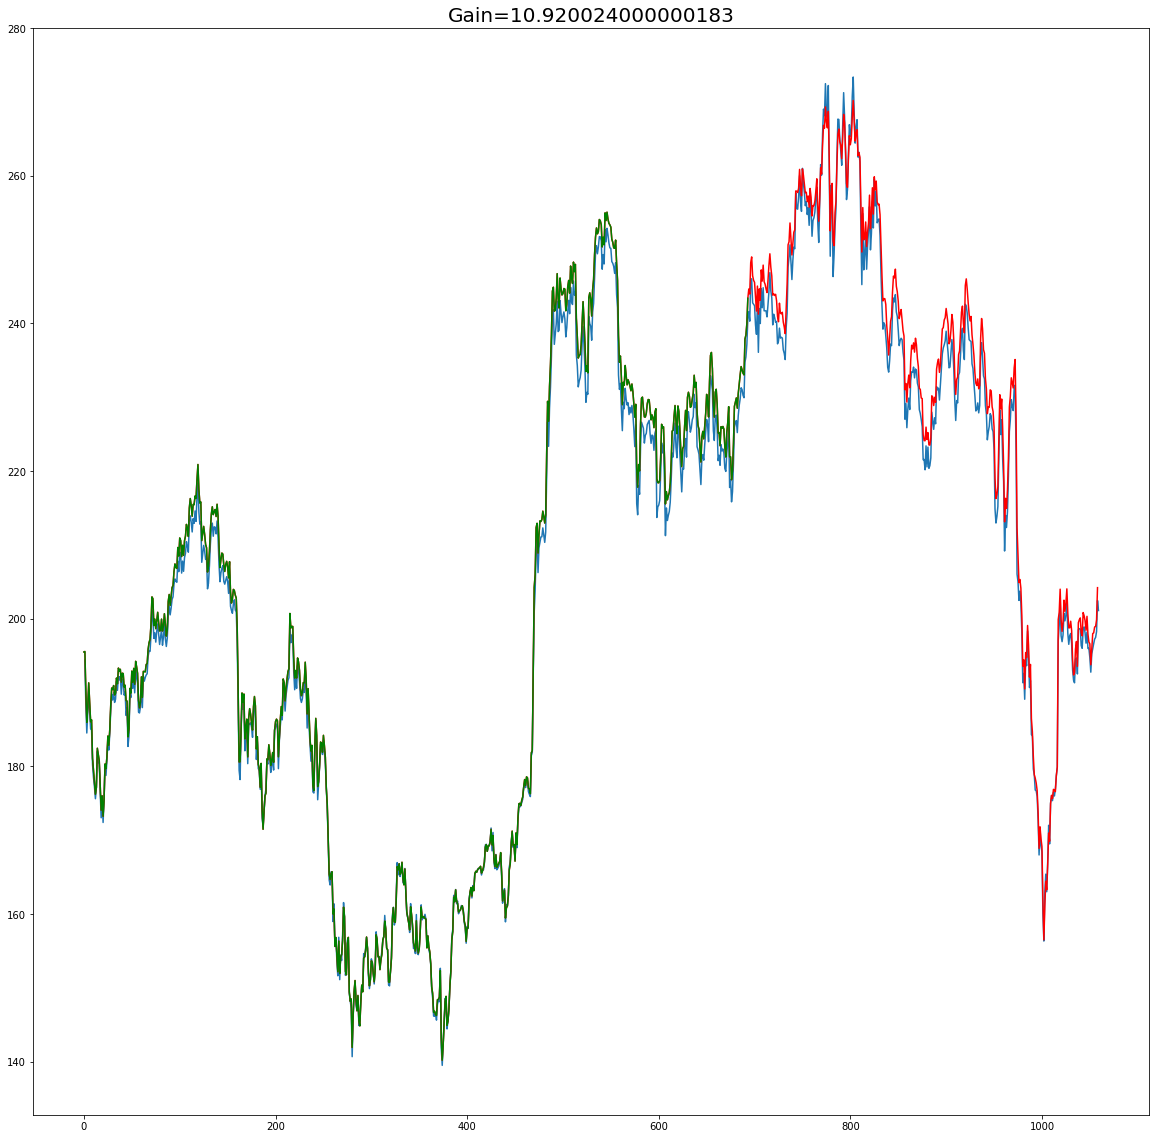

In [ ]:
prices=prices.rename(columns={'GS_Close':'GS_Close(t)'})
actual=prices["GS_Close(t)"][len(prices)-len(Xtest_t):]
use=prices["GS_Close(t)"][len(prices)-len(Xtest_t)-1:]

plt.figure(figsize=(20,20))
plt.plot(prices['GS_Close(t)'])

plt.plot(all_predictions_t,'r')
plt.plot(trainPredict_t,'g')
plt.title('Gain={}'.format(np.sum(gainz(testPredict_t,actual,use))),size=20)

### LSTM with memory between batches

In [ ]:
Xtrain_f,ytrain_f,Xtest_f,ytest_f,scaler_x_f,scaler_y_f=transform_features(prices)

model_lstm = tensorflow.keras.models.Sequential()
model_lstm.add(layers.LSTM(50, input_shape=(Xtrain_f.shape[1], Xtrain_f.shape[2]),return_sequences=True))
model_lstm.add(layers.LSTM(30, input_shape=(Xtrain_f.shape[1], Xtrain_f.shape[2])))
model_lstm.add(layers.Dense(1))
opt=tensorflow.keras.optimizers.Adam(lr=0.01,epsilon=None,decay=0)
model_lstm.compile(loss='mse', optimizer=opt)
for i in range(100):
    model_lstm.fit(Xtrain_f,ytrain_f, epochs=1, batch_size=20, validation_data=(Xtest_f,ytest_f),verbose=1,shuffle=False)
    model_lstm.reset_states()
    
trainPredict_mem=model_lstm.predict(Xtrain_f)
model_lstm.reset_states()
testPredict_mem= model_lstm.predict(Xtest_f)

all_predictions_mem=[]
trainPredict_mem=scaler_y_f.inverse_transform(trainPredict_mem)
testPredict_mem=scaler_y_f.inverse_transform(testPredict_mem)
all_predictions_mem=np.append(trainPredict_mem,testPredict_mem)


Train on 694 samples, validate on 365 samples
Epoch 1/1
694/694 [==============================] - 11s 16ms/step - loss: 0.0974 - val_loss: 0.0735
Train on 694 samples, validate on 365 samples
Epoch 1/1
694/694 [==============================] - 0s 279us/step - loss: 0.0546 - val_loss: 0.0323
Train on 694 samples, validate on 365 samples
Epoch 1/1
694/694 [==============================] - 0s 272us/step - loss: 0.0544 - val_loss: 0.0177
Train on 694 samples, validate on 365 samples
Epoch 1/1
694/694 [==============================] - 0s 267us/step - loss: 0.0434 - val_loss: 0.0135
Train on 694 samples, validate on 365 samples
Epoch 1/1
694/694 [==============================] - 0s 267us/step - loss: 0.0264 - val_loss: 0.0155
Train on 694 samples, validate on 365 samples
Epoch 1/1
694/694 [==============================] - 0s 269us/step - loss: 0.0168 - val_loss: 0.0137
Train on 694 samples, validate on 365 samples
Epoch 1/1
694/694 [==============================] - 0s 276us/step - los

Text(0.5, 1.0, 'Gain=68.90005599999984')

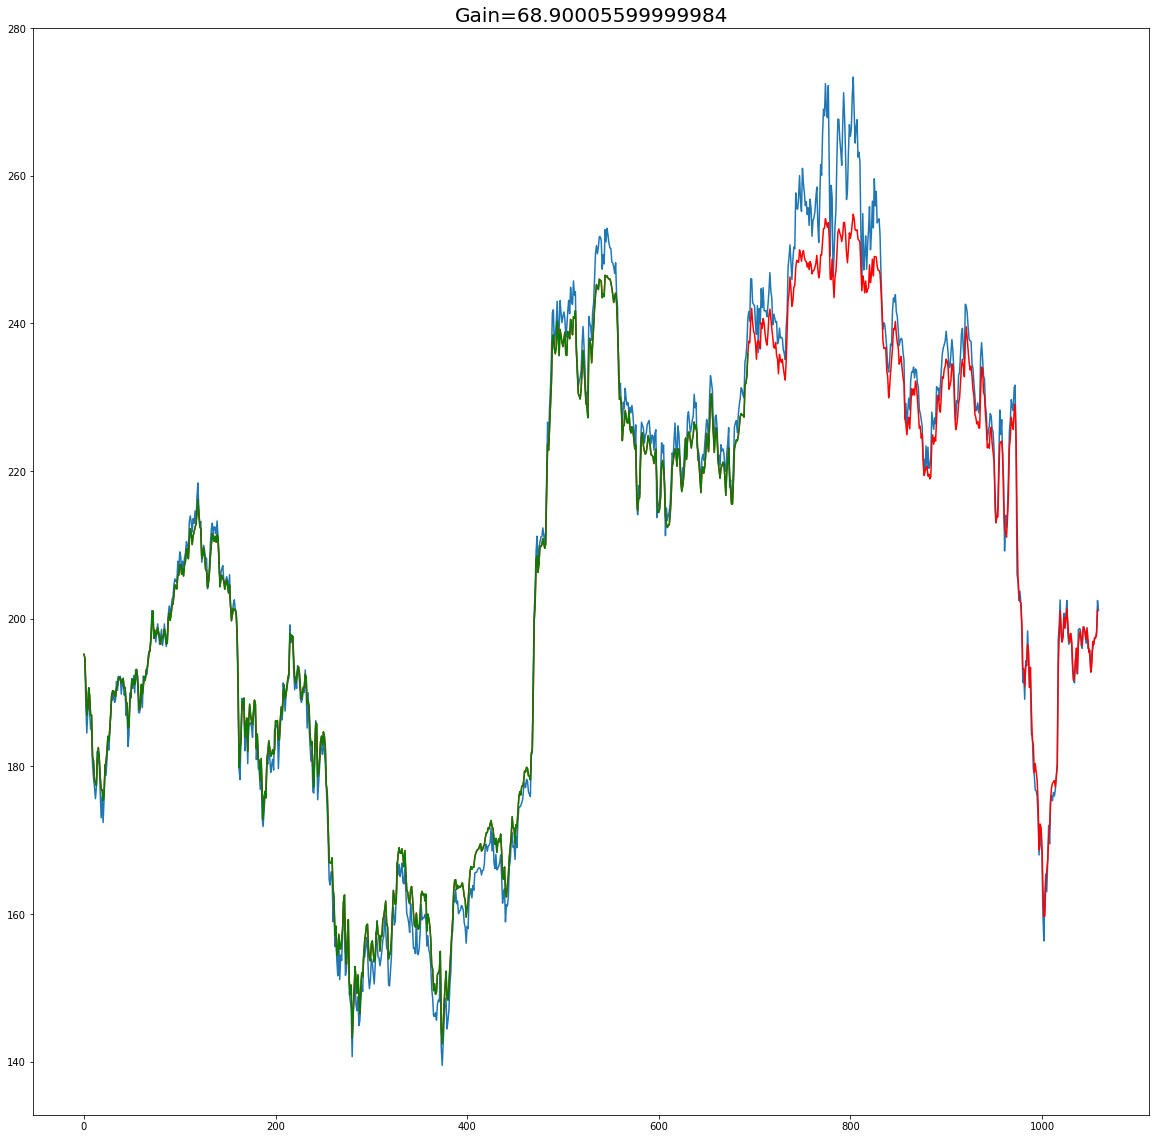

In [ ]:
prices=prices.rename(columns={'GS_Close':'GS_Close(t)'})
actual=prices["GS_Close(t)"][len(prices)-len(Xtest_f):]
use=prices["GS_Close(t)"][len(prices)-len(Xtest_f)-1:]

plt.figure(figsize=(20,20))
plt.plot(prices['GS_Close(t)'])

plt.plot(all_predictions_mem,'r')
plt.plot(trainPredict_mem,'g')
plt.title('Gain={}'.format(np.sum(gainz(testPredict_mem,actual,use))),size=20)

### Adding Dropout

In [ ]:
Xtrain_f,ytrain_f,Xtest_f,ytest_f,scaler_x_f,scaler_y_f=transform_features(prices)

model_lstm = tensorflow.keras.models.Sequential()
model_lstm.add(layers.LSTM(50, input_shape=(Xtrain_f.shape[1], Xtrain_f.shape[2]),return_sequences=True))
model_lstm.add(layers.Dropout(0.2))
model_lstm.add(layers.LSTM(30, input_shape=(Xtrain_f.shape[1], Xtrain_f.shape[2])))
model_lstm.add(layers.Dense(1))
opt=tensorflow.keras.optimizers.Adam(lr=0.01,epsilon=None,decay=0)
model_lstm.compile(loss='mse', optimizer=opt)
for i in range(100):
    model_lstm.fit(Xtrain_f,ytrain_f, epochs=1, batch_size=20, validation_data=(Xtest_f,ytest_f),verbose=1,shuffle=False)
    model_lstm.reset_states()
    
trainPredict_mem=model_lstm.predict(Xtrain_f)
model_lstm.reset_states()
testPredict_mem= model_lstm.predict(Xtest_f)

all_predictions_mem=[]
trainPredict_mem=scaler_y_f.inverse_transform(trainPredict_mem)
testPredict_mem=scaler_y_f.inverse_transform(testPredict_mem)
all_predictions_mem=np.append(trainPredict_mem,testPredict_mem)


Train on 694 samples, validate on 365 samples
Epoch 1/1
694/694 [==============================] - 12s 17ms/step - loss: 0.1008 - val_loss: 0.0702
Train on 694 samples, validate on 365 samples
Epoch 1/1
694/694 [==============================] - 0s 305us/step - loss: 0.0749 - val_loss: 0.0212
Train on 694 samples, validate on 365 samples
Epoch 1/1
694/694 [==============================] - 0s 293us/step - loss: 0.0719 - val_loss: 0.0209
Train on 694 samples, validate on 365 samples
Epoch 1/1
694/694 [==============================] - 0s 305us/step - loss: 0.0424 - val_loss: 0.0125
Train on 694 samples, validate on 365 samples
Epoch 1/1
694/694 [==============================] - 0s 299us/step - loss: 0.0242 - val_loss: 0.0132
Train on 694 samples, validate on 365 samples
Epoch 1/1
694/694 [==============================] - 0s 299us/step - loss: 0.0162 - val_loss: 0.0126
Train on 694 samples, validate on 365 samples
Epoch 1/1
694/694 [==============================] - 0s 285us/step - los

Text(0.5, 1.0, 'Gain=93.18005599999975')

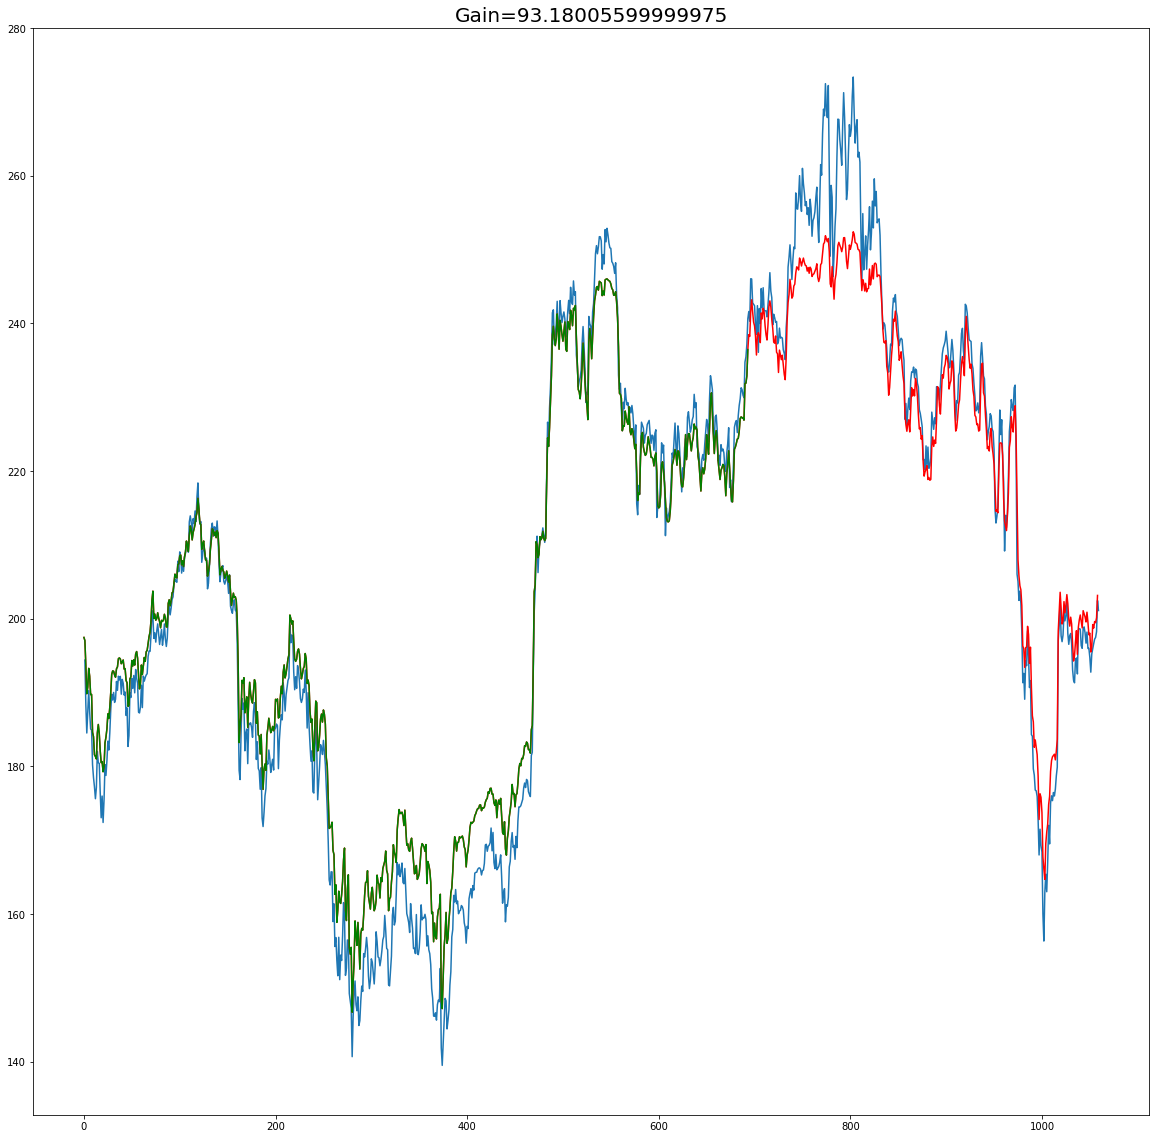

In [ ]:
prices=prices.rename(columns={'GS_Close':'GS_Close(t)'})
actual=prices["GS_Close(t)"][len(prices)-len(Xtest_f):]
use=prices["GS_Close(t)"][len(prices)-len(Xtest_f)-1:]

plt.figure(figsize=(20,20))
plt.plot(prices['GS_Close(t)'])

plt.plot(all_predictions_mem,'r')
plt.plot(trainPredict_mem,'g')
plt.title('Gain={}'.format(np.sum(gainz(testPredict_mem,actual,use))),size=20)

# More More More

In [ ]:
#more stocks, indicators, etc.
prices=pd.read_csv("all_stocks/GS.csv")
n_in=1
n_out=1
prices.drop(['Date'],axis=1,inplace=True)
prices=to_supervised(prices,n_in,n_out)
names=[]
for i in prices.columns:
    names.append('GS_{}'.format(i))
prices.columns=names
prices.head()

extra=pd.read_csv("all_stocks/^IXIC.csv") #NASDAQ
extra.drop(['Date','Open','Low','High','Volume'],axis=1,inplace=True)
extra=extra.rename (columns= {"Close":"^IXIC_Close"} )
prices=prices.join(extra)

extra=pd.read_csv("all_stocks/^VIX.csv") #volatility index
extra.drop(['Date','Open','Low','High','Volume'],axis=1,inplace=True)
extra=extra.rename (columns= {"Close":"^VIX_Close"} )
prices=prices.join(extra)

extra=pd.read_csv("all_stocks/BAC.csv") #Bank of America
extra.drop(['Date','Open','Low','High','Volume'],axis=1,inplace=True)
extra=extra.rename (columns= {"Close":"BAC_Close"} )
prices=prices.join(extra)

extra=pd.read_csv("all_stocks/BCS.csv") #Barclays
extra.drop(['Date','Open','Low','High','Volume'],axis=1,inplace=True)
extra=extra.rename (columns= {"Close":"BCS_Close"} )
prices=prices.join(extra)

extra=pd.read_csv("all_stocks/CS.csv") #Credit Suisse
extra.drop(['Date','Open','Low','High','Volume'],axis=1,inplace=True)
extra=extra.rename (columns= {"Close":"CS_Close"} )
prices=prices.join(extra)

extra=pd.read_csv("all_stocks/JPM.csv") #JP Morgan
extra.drop(['Date','Open','Low','High','Volume'],axis=1,inplace=True)
extra=extra.rename (columns= {"Close":"JPM_Close"} )
prices=prices.join(extra)

extra=pd.read_csv("all_stocks/MS.csv") #Morgan Stanley
extra.drop(['Date','Open','Low','High','Volume'],axis=1,inplace=True)
extra=extra.rename (columns= {"Close":"MS_Close"} )
prices=prices.join(extra)

extra=pd.read_csv("all_stocks/HSI.csv") #Hang Seng
extra.drop(['Date','Open','Low','High','Volume'],axis=1,inplace=True)
extra=extra.rename (columns= {"Close":"HSI_Close"} )

prices=prices.join(extra)
prices['HSI_Close']=prices['HSI_Close'].shift(9)

extra=pd.read_csv("all_stocks/NYA.csv") #NYSE
extra.drop(['Date','Open','Low','High','Volume'],axis=1,inplace=True)
extra=extra.rename (columns= {"Close":"NYA_Close"} )
prices=prices.join(extra)
prices['NYA_Close']=prices['NYA_Close'].shift(149)

extra=pd.read_csv("all_stocks/^N225.csv") #NIKKEI
extra.drop(['Date','Open','Low','High','Volume'],axis=1,inplace=True)
extra=extra.rename (columns= {"Close":"^N225_Close"} )
prices=prices.join(extra)
prices['^N225_Close']=prices['^N225_Close'].shift(25)

In [ ]:
prices.head()


GS_Open(t-1)  GS_High(t-1)  GS_Low(t-1)  GS_Close(t-1)  GS_Volume(t-1)  \
1    196.649994    196.830002   193.770004     193.830002       1566800.0   
2    195.300003    195.729996   192.699997     194.410004       1877700.0   
3    193.059998    194.039993   187.479996     188.339996       3413200.0   
4    188.300003    188.660004   183.929993     184.529999       3429200.0   
5    186.850006    187.990005   185.770004     187.279999       1896800.0   

   GS_Close(t)  ^IXIC_Close  ^VIX_Close  BAC_Close  BCS_Close   CS_Close  \
1   194.410004  4726.810059   17.790001  17.900000      14.92  24.990000   
2   188.339996  4652.569824   19.920000  17.379999      14.31  24.240000   
3   184.529999  4592.740234   21.120001  16.860001      14.00  23.809999   
4   187.279999  4650.470215   19.309999  16.940001      14.04  23.790001   
5   190.270004  4736.189941   17.010000  17.290001      14.28  23.610001   

   JPM_Close   MS_Close  HSI_Close  NYA_Close  ^N225_Close  
1  62.490002  38.709999        NaN        NaN          NaN  
2  60.549999  37.500000        NaN        NaN          NaN  
3  58.980000  36.419998        NaN        NaN          NaN  
4  59.070000  36.939999        NaN        NaN          NaN  
5  60.389999  37.490002        NaN        NaN          NaN

In [ ]:
# Create 7 and 21 days Moving Average
prices['ma7'] = prices['GS_Close(t-1)'].rolling(window=7).mean()
prices['ma21'] = prices['GS_Close(t-1)'].rolling(window=21).mean()

# Create MACD
prices['26ema'] = prices['GS_Close(t-1)'].ewm(span=26).mean()
prices['12ema'] = prices['GS_Close(t-1)'].ewm(span=12).mean()
prices['MACD'] = (prices['12ema']-prices['26ema'])

# Create Bollinger Bands
prices['20sd'] = prices['GS_Close(t-1)'].rolling(20).std()
prices['upper_band'] = prices['ma21'] + (prices['20sd']*2)
prices['lower_band'] = prices['ma21'] - (prices['20sd']*2)

# Create Exponential moving average
prices['ema'] = prices['GS_Close(t-1)'].ewm(com=0.5).mean()

# Create Momentum
prices['momentum'] = prices['GS_Close(t-1)']-1

# Create log Momentum
prices['log_momentum'] = np.log(prices['momentum'])

In [ ]:
prices.head()

GS_Open(t-1)  GS_High(t-1)  GS_Low(t-1)  GS_Close(t-1)  GS_Volume(t-1)  \
1    196.649994    196.830002   193.770004     193.830002       1566800.0   
2    195.300003    195.729996   192.699997     194.410004       1877700.0   
3    193.059998    194.039993   187.479996     188.339996       3413200.0   
4    188.300003    188.660004   183.929993     184.529999       3429200.0   
5    186.850006    187.990005   185.770004     187.279999       1896800.0   

   GS_Close(t)  ^IXIC_Close  ^VIX_Close  BAC_Close  BCS_Close  ...  ma21  \
1   194.410004  4726.810059   17.790001  17.900000      14.92  ...   NaN   
2   188.339996  4652.569824   19.920000  17.379999      14.31  ...   NaN   
3   184.529999  4592.740234   21.120001  16.860001      14.00  ...   NaN   
4   187.279999  4650.470215   19.309999  16.940001      14.04  ...   NaN   
5   190.270004  4736.189941   17.010000  17.290001      14.28  ...   NaN   

        26ema       12ema      MACD  20sd  upper_band  lower_band         ema  \
1  193.830002  193.830002  0.000000   NaN         NaN         NaN  193.830002   
2  194.131157  194.144170  0.013013   NaN         NaN         NaN  194.265003   
3  192.050449  191.878799 -0.171650   NaN         NaN         NaN  190.163075   
4  189.948060  189.559070 -0.388990   NaN         NaN         NaN  186.360749   
5  189.329326  188.939855 -0.389471   NaN         NaN         NaN  186.976115   

     momentum  log_momentum  
1  192.830002      5.261809  
2  193.410004      5.264812  
3  187.339996      5.232925  
4  183.529999      5.212378  
5  186.279999      5.227251  

[5 rows x 27 columns]

In [ ]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ = list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['GS_Close(t)'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Goldman Sachs - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['log_momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

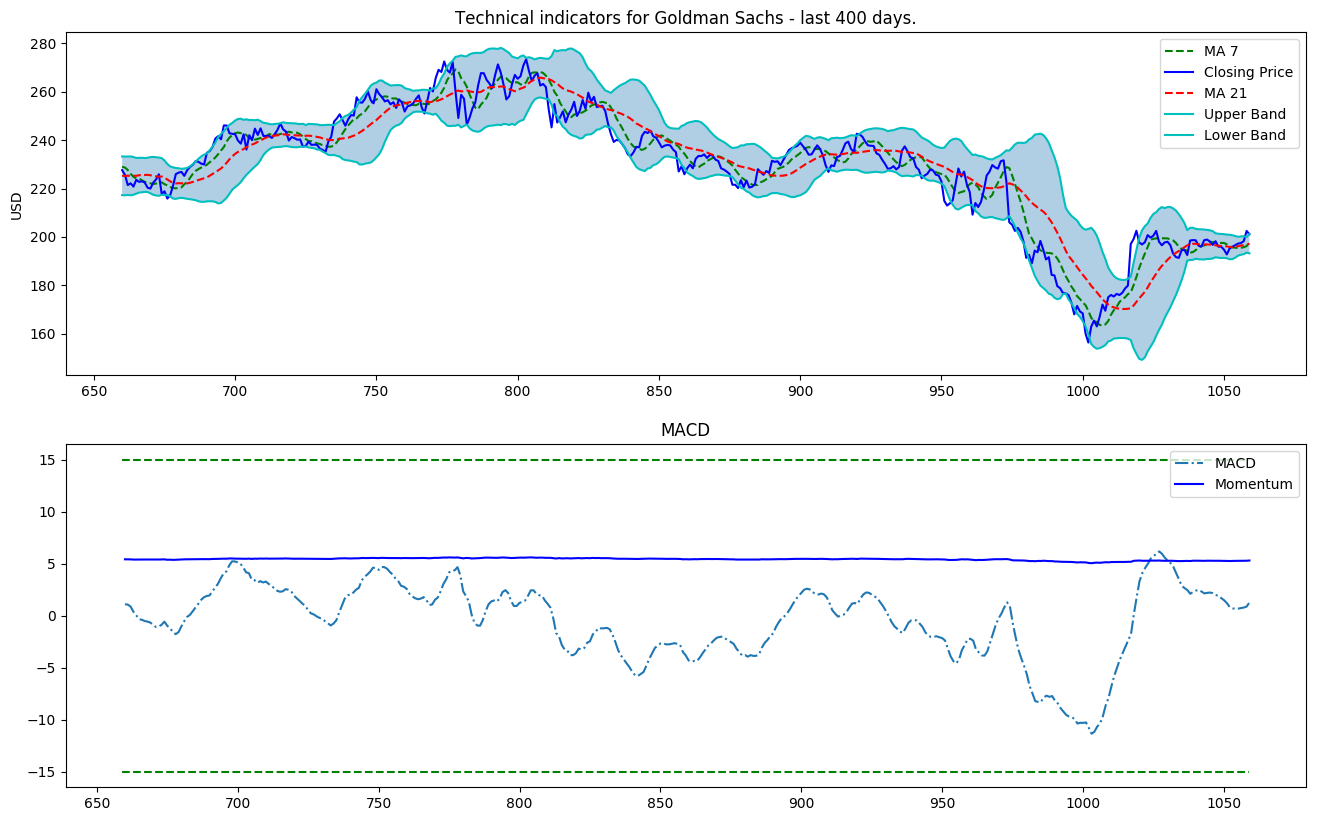

In [ ]:
plot_technical_indicators(prices, 400)

In [ ]:
def filter_signal10(signal, threshold=1e3):
    fourier = rfft(signal)
    frequencies = rfftfreq(signal.size, d=10e-3/signal.size)  #change the number to change the plot
    fourier[frequencies > threshold] = 0
    return irfft(fourier)

def filter_signal20(signal, threshold=1e3):
    fourier = rfft(signal)
    frequencies = rfftfreq(signal.size, d=20e-3/signal.size)  #change the number to change the plot
    fourier[frequencies > threshold] = 0
    return irfft(fourier)

def filter_signal30(signal, threshold=1e3):
    fourier = rfft(signal)
    frequencies = rfftfreq(signal.size, d=30e-3/signal.size)  #change the number to change the plot
    fourier[frequencies > threshold] = 0
    return irfft(fourier)

In [ ]:
fourier=filter_signal10(prices['GS_Close(t-1)'])
fourier=pd.DataFrame(fourier)
fourier=fourier.rename(columns={0:'fourier10'})
prices=prices.join(fourier)
prices['fourier10']=prices['fourier10'].shift(2)

fourier=filter_signal20(prices['GS_Close(t-1)'])
fourier=pd.DataFrame(fourier)
fourier=fourier.rename(columns={0:'fourier20'})
prices=prices.join(fourier)
prices['fourier20']=prices['fourier20'].shift(2)

fourier=filter_signal30(prices['GS_Close(t-1)'])
fourier=pd.DataFrame(fourier)
fourier=fourier.rename(columns={0:'fourier30'})
prices=prices.join(fourier)
prices['fourier30']=prices['fourier30'].shift(2)

prices=prices.shift(-149).dropna()

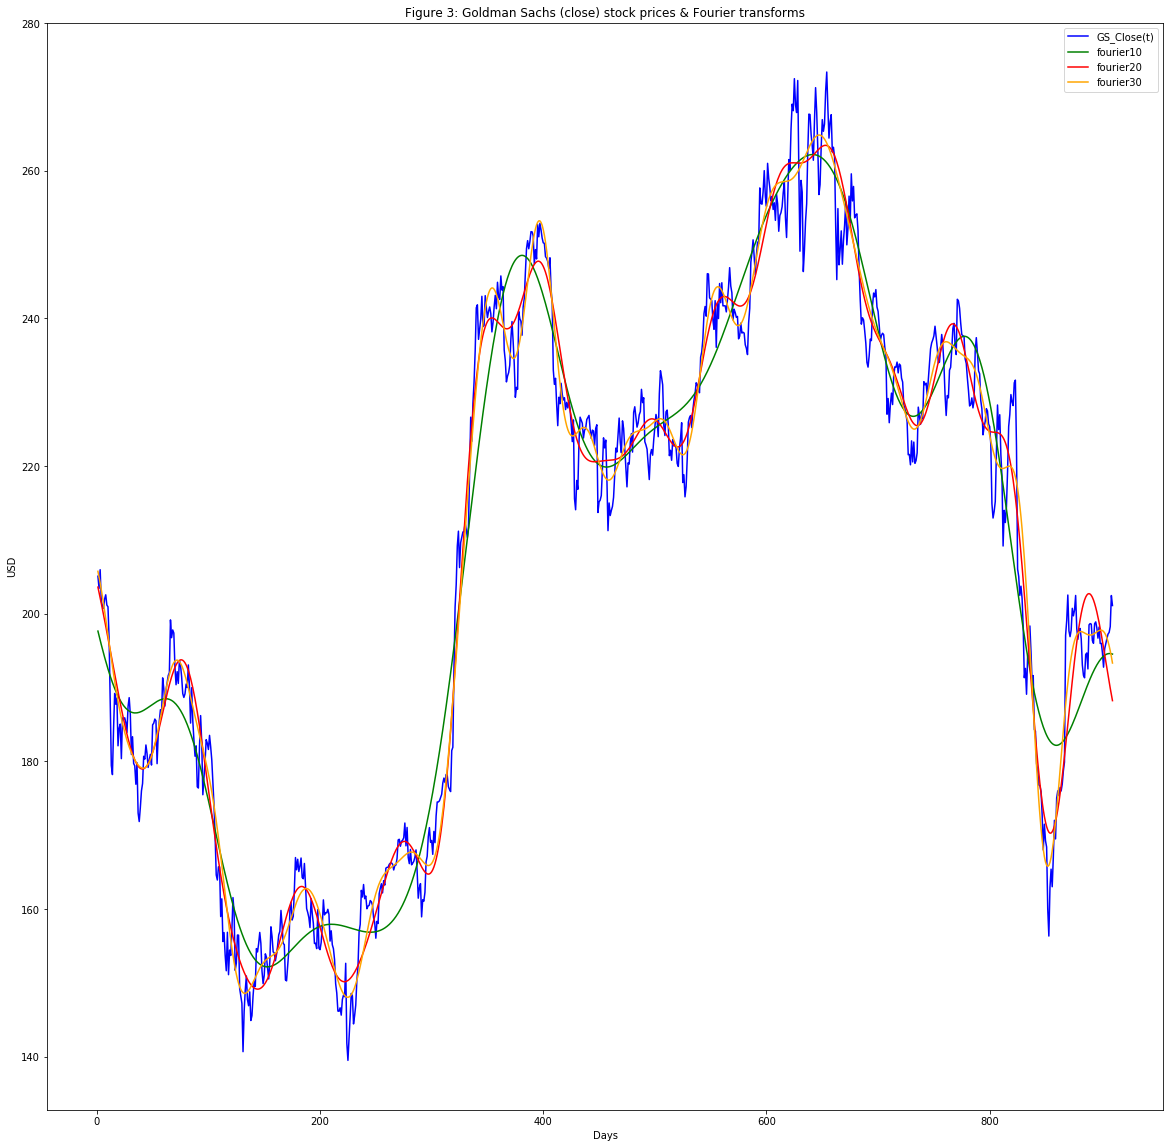

In [ ]:
plt.figure(figsize=(20,20))
plt.plot(prices['GS_Close(t)'],color='blue')
plt.plot(prices['fourier10'],color='green')
plt.plot(prices['fourier20'],color='red')
plt.plot(prices['fourier30'],color='orange')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 3: Goldman Sachs (close) stock prices & Fourier transforms')
plt.legend()

In [ ]:
prices.shape

(910, 30)

In [ ]:
prices.head()

GS_Open(t-1)  GS_High(t-1)  GS_Low(t-1)  GS_Close(t-1)  GS_Volume(t-1)  \
1    206.940002    207.779999   204.929993     205.699997       1535500.0   
2    206.000000    206.699997   204.300003     205.089996       1485800.0   
3    205.300003    206.639999   202.320007     203.440002       1691100.0   
4    204.589996    206.570007   204.339996     205.970001       1640300.0   
5    203.500000    203.919998   200.660004     201.699997       2434300.0   

   GS_Close(t)  ^IXIC_Close  ^VIX_Close  BAC_Close  BCS_Close  ...      MACD  \
1   205.089996  5056.439941       13.77  17.809999  17.490000  ... -1.220505   
2   203.440002  5043.540039       13.39  17.750000  17.450001  ... -1.277592   
3   205.970001  5101.799805       12.23  18.040001  17.559999  ... -1.439382   
4   201.699997  5036.790039       13.71  17.790001  17.309999  ... -1.347915   
5   201.130005  5044.390137       13.61  17.520000  17.160000  ... -1.601516   

       20sd  upper_band  lower_band         ema    momentum  log_momentum  \
1  3.205462  214.811402  201.989552  205.508078  204.699997      5.321545   
2  3.188525  214.826574  202.072475  205.229357  204.089996      5.318561   
3  3.382134  215.148554  201.620020  204.036454  202.440002      5.310444   
4  3.401148  215.128487  201.523896  205.325485  204.970001      5.322864   
5  3.566288  215.057814  200.792664  202.908493  200.699997      5.301811   

    fourier10   fourier20   fourier30  
1  197.654110  203.613807  205.754268  
2  197.033698  202.899114  204.993247  
3  196.423316  202.168781  204.169311  
4  195.824202  201.424049  203.287349  
5  195.237540  200.666167  202.353316  

[5 rows x 30 columns]

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame
from pandas import datetime

series = prices['GS_Close(t)']
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:          D.GS_Close(t)   No. Observations:                  909
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -2339.537
Method:                       css-mle   S.D. of innovations              3.173
Date:                Mon, 27 May 2019   AIC                           4693.073
Time:                        07:47:17   BIC                           4726.759
Sample:                             1   HQIC                          4705.935
                                                                              
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0044      0.102     -0.043      0.965      -0.204       0.196
ar.L1.D.GS_Close(t)     0.0256      0.033      0.774      0.439      -0.039       0.091
ar.L2.D.GS_Close

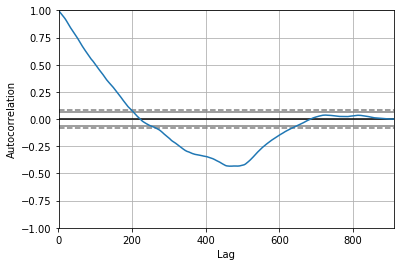

<Figure size 800x560 with 0 Axes>

In [ ]:
# from pandas import autocorrelation_plot
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.figure(figsize=(10, 7), dpi=80)
plt.show() 

In [ ]:
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

In [ ]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 13.408


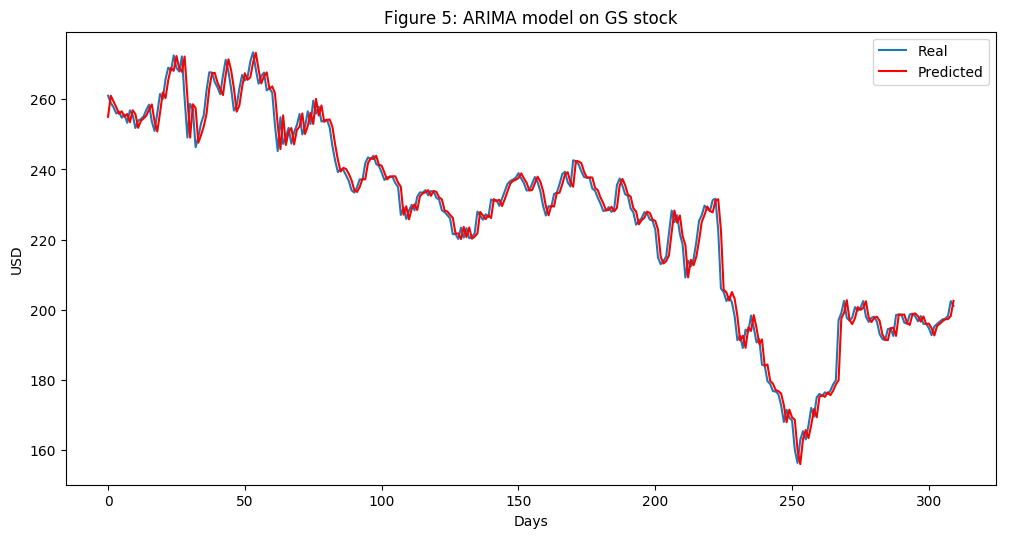

In [ ]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, label='Real')
plt.plot(predictions, color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 5: ARIMA model on GS stock')
plt.legend()
plt.show()

### Simple LSTM & passing data as features

In [ ]:
Xtrain_f,ytrain_f,Xtest_f,ytest_f,scaler_x_f,scaler_y_f=transform_features(prices)

model_lstm = tensorflow.keras.models.Sequential()
model_lstm.add(layers.LSTM(50, input_shape=(Xtrain_f.shape[1], Xtrain_f.shape[2])))
model_lstm.add(layers.Dense(1))
opt=tensorflow.keras.optimizers.Adam(lr=0.01,epsilon=None,decay=0)
model_lstm.compile(loss='mse', optimizer=opt)

earlyStopping =EarlyStopping(monitor='val_loss', patience=50, verbose=0, mode='min')
mcp_save = ModelCheckpoint('simple_lstm_5.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=70, verbose=1,min_delta=0.001, mode='min')

model_lstm.fit(Xtrain_f,ytrain_f, epochs=60, batch_size=20, validation_data=(Xtest_f,ytest_f),verbose=1,callbacks=[earlyStopping, mcp_save, reduce_lr_loss])

trainPredict_f=model_lstm.predict(Xtrain_f)
testPredict_f= model_lstm.predict(Xtest_f)

all_predictions_f=[]
trainPredict_f=scaler_y_f.inverse_transform(trainPredict_f)
testPredict_f=scaler_y_f.inverse_transform(testPredict_f)
all_predictions_f=np.append(trainPredict_f,testPredict_f)

Train on 545 samples, validate on 365 samples
Epoch 1/60
545/545 [==============================] - 20s 38ms/step - loss: 0.0305 - val_loss: 0.0165
Epoch 2/60
545/545 [==============================] - 0s 465us/step - loss: 0.0022 - val_loss: 0.0080
Epoch 3/60
545/545 [==============================] - 0s 511us/step - loss: 0.0011 - val_loss: 0.0063
Epoch 4/60
545/545 [==============================] - 0s 497us/step - loss: 9.1546e-04 - val_loss: 0.0042
Epoch 5/60
545/545 [==============================] - 0s 419us/step - loss: 7.7313e-04 - val_loss: 0.0033
Epoch 6/60
545/545 [==============================] - 0s 427us/step - loss: 6.7371e-04 - val_loss: 0.0026
Epoch 7/60
545/545 [==============================] - 0s 513us/step - loss: 5.9896e-04 - val_loss: 0.0022
Epoch 8/60
545/545 [==============================] - 0s 445us/step - loss: 5.8703e-04 - val_loss: 0.0020
Epoch 9/60
545/545 [==============================] - 0s 436us/step - loss: 5.6721e-04 - val_loss: 0.0018-0
Epoch 10/6

Text(0.5, 1.0, 'Gain=532.4400239999997')

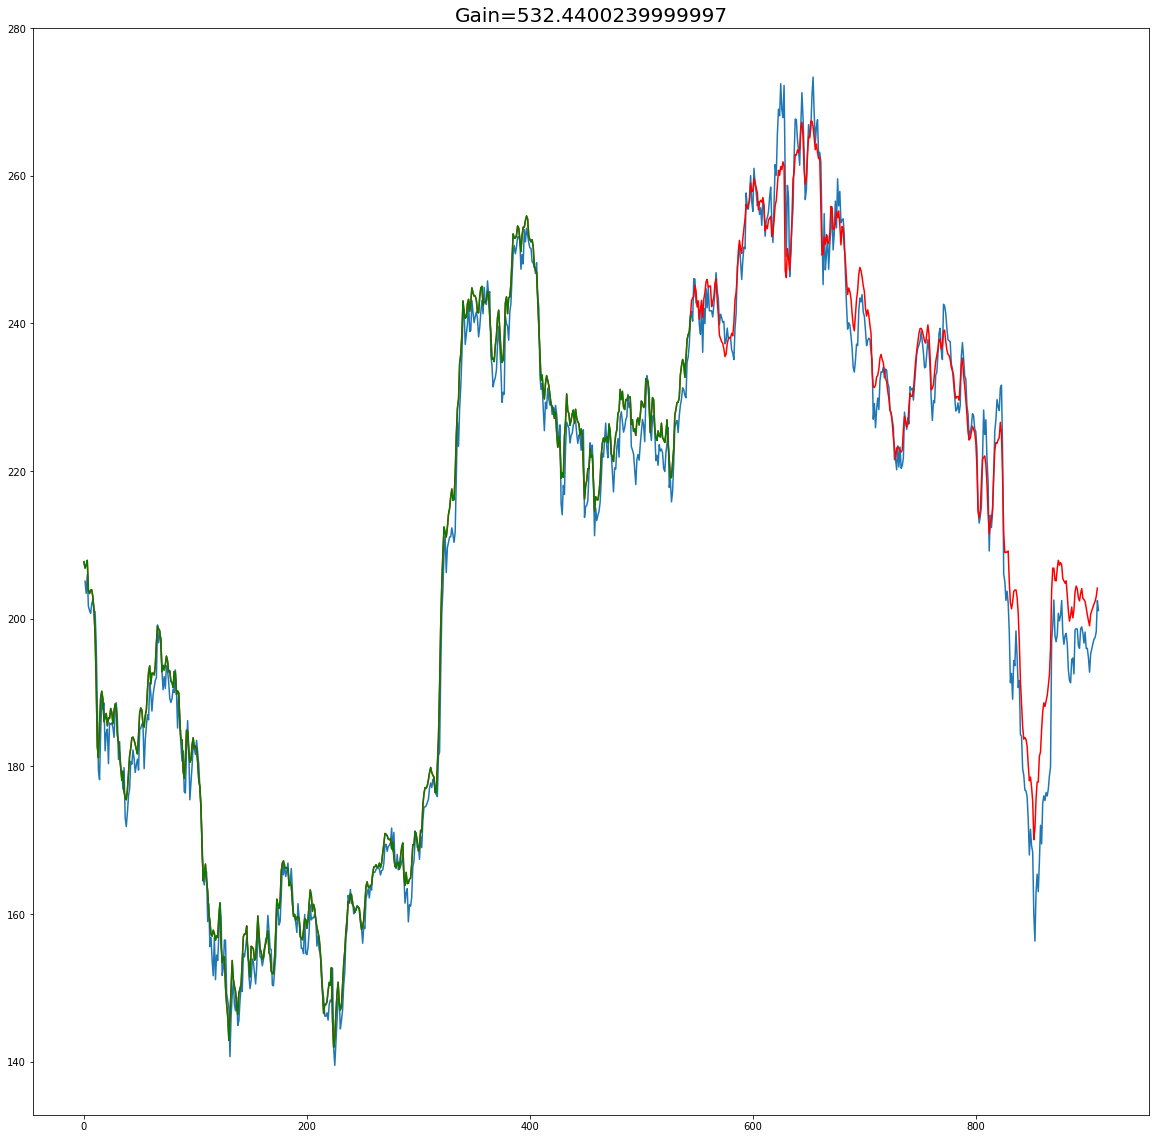

In [ ]:
prices=prices.rename(columns={'GS_Close':'GS_Close(t)'})
actual=prices["GS_Close(t)"][len(prices)-len(Xtest_f):]
use=prices["GS_Close(t)"][len(prices)-len(Xtest_f)-1:]

plt.figure(figsize=(20,20))
plt.plot(prices['GS_Close(t)'])

plt.plot(all_predictions_f,'r')
plt.plot(trainPredict_f,'g')
plt.title('Gain={}'.format(np.sum(gainz(testPredict_f,actual,use))),size=20)

### Simple LSTM & passing data as timesteps

In [ ]:
Xtrain_t,ytrain_t,Xtest_t,ytest_t,scaler_x_t,scaler_y_t=transform_timesteps(prices)

model_lstm = tensorflow.keras.models.Sequential()
model_lstm.add(layers.LSTM(80, input_shape=(Xtrain_t.shape[1], Xtrain_t.shape[2])))
model_lstm.add(layers.Dense(1))
opt=tensorflow.keras.optimizers.Adam(lr=0.01,epsilon=None,decay=0)
model_lstm.compile(loss='mse', optimizer=opt)

earlyStopping =EarlyStopping(monitor='val_loss', patience=50, verbose=0, mode='min')
mcp_save = ModelCheckpoint('simple_lstm_6.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=70, verbose=1,min_delta=0.001, mode='min')

model_lstm.fit(Xtrain_t,ytrain_t, epochs=60, batch_size=20, validation_data=(Xtest_t, ytest_t),verbose=1,callbacks=[earlyStopping, mcp_save, reduce_lr_loss])

trainPredict_t=model_lstm.predict(Xtrain_t)
testPredict_t= model_lstm.predict(Xtest_t)

all_predictions_t=[]
trainPredict_t=scaler_y_t.inverse_transform(trainPredict_t)
testPredict_t=scaler_y_t.inverse_transform(testPredict_t)
all_predictions_t=np.append(trainPredict_t,testPredict_t)

Train on 545 samples, validate on 365 samples
Epoch 1/60
545/545 [==============================] - 2s 4ms/step - loss: 0.0595 - val_loss: 0.0052
Epoch 2/60
545/545 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 3/60
545/545 [==============================] - 1s 3ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 4/60
545/545 [==============================] - 1s 3ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 5/60
545/545 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 6/60
545/545 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 0.0019
Epoch 7/60
545/545 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 8/60
545/545 [==============================] - 1s 2ms/step - loss: 0.0010 - val_loss: 0.0016
Epoch 9/60
545/545 [==============================] - 1s 2ms/step - loss: 9.9815e-04 - val_loss: 0.0023
Epoch 10/60
545/545 [=============================

Text(0.5, 1.0, 'Gain=180.36000999999965')

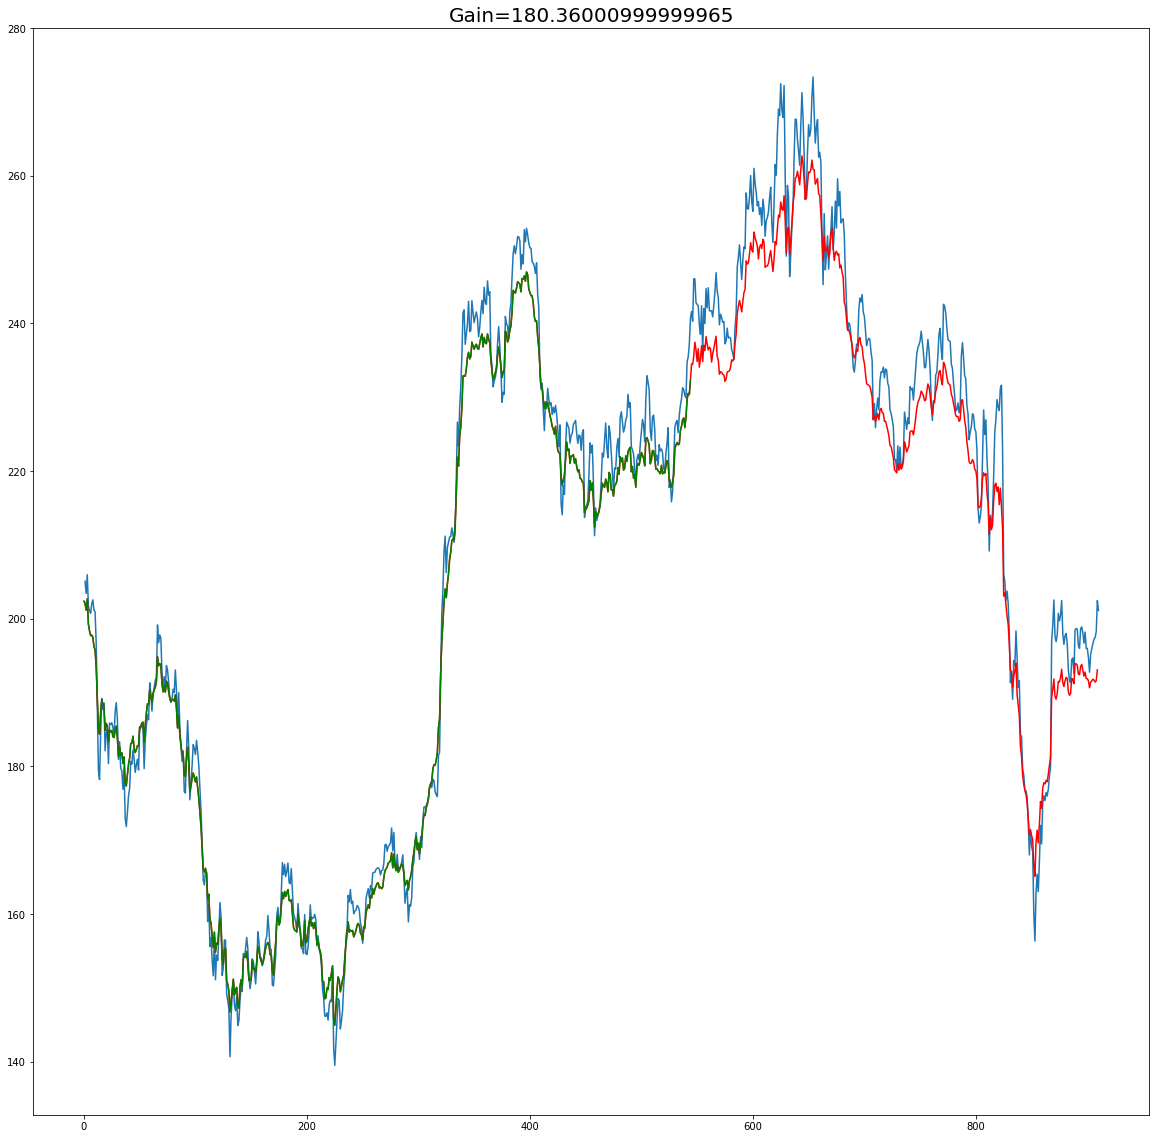

In [ ]:
prices=prices.rename(columns={'GS_Close':'GS_Close(t)'})

actual=prices["GS_Close(t)"][len(prices)-len(Xtest_t):]
use=prices["GS_Close(t)"][len(prices)-len(Xtest_t)-1:]

plt.figure(figsize=(20,20))
plt.plot(prices['GS_Close(t)'])

plt.plot(all_predictions_t,'r')
plt.plot(trainPredict_t,'g')
plt.title('Gain={}'.format(np.sum(gainz(testPredict_t,actual,use))),size=20)

### Simple LSTM with memory between batches

In [ ]:
Xtrain_f,ytrain_f,Xtest_f,ytest_f,scaler_x_f,scaler_y_f=transform_features(prices)

model_lstm = tensorflow.keras.models.Sequential()
model_lstm.add(layers.LSTM(50, input_shape=(Xtrain_f.shape[1], Xtrain_f.shape[2])))
model_lstm.add(layers.Dense(1))
opt=tensorflow.keras.optimizers.Adam(lr=0.001,epsilon=None,decay=0)
model_lstm.compile(loss='mse', optimizer=opt)
for i in range(50):
    model_lstm.fit(Xtrain_f,ytrain_f, epochs=1, batch_size=20, validation_data=(Xtest_f,ytest_f),verbose=1,shuffle=False)
    model_lstm.reset_states()
    
trainPredict_mem=model_lstm.predict(Xtrain_f)
model_lstm.reset_states()
testPredict_mem= model_lstm.predict(Xtest_f)

all_predictions_mem=[]
trainPredict_mem=scaler_y_f.inverse_transform(trainPredict_mem)
testPredict_mem=scaler_y_f.inverse_transform(testPredict_mem)
all_predictions_mem=np.append(trainPredict_mem,testPredict_mem)

Train on 545 samples, validate on 365 samples
Epoch 1/1
545/545 [==============================] - 12s 22ms/step - loss: 0.0546 - val_loss: 0.0340
Train on 545 samples, validate on 365 samples
Epoch 1/1
545/545 [==============================] - 0s 240us/step - loss: 0.0163 - val_loss: 0.0083
Train on 545 samples, validate on 365 samples
Epoch 1/1
545/545 [==============================] - 0s 251us/step - loss: 0.0042 - val_loss: 0.0129
Train on 545 samples, validate on 365 samples
Epoch 1/1
545/545 [==============================] - 0s 274us/step - loss: 0.0020 - val_loss: 0.0051
Train on 545 samples, validate on 365 samples
Epoch 1/1
545/545 [==============================] - 0s 282us/step - loss: 0.0012 - val_loss: 0.0046
Train on 545 samples, validate on 365 samples
Epoch 1/1
545/545 [==============================] - 0s 265us/step - loss: 0.0011 - val_loss: 0.0040
Train on 545 samples, validate on 365 samples
Epoch 1/1
545/545 [==============================] - 0s 249us/step - los

Text(0.5, 1.0, 'Gain=284.900032')

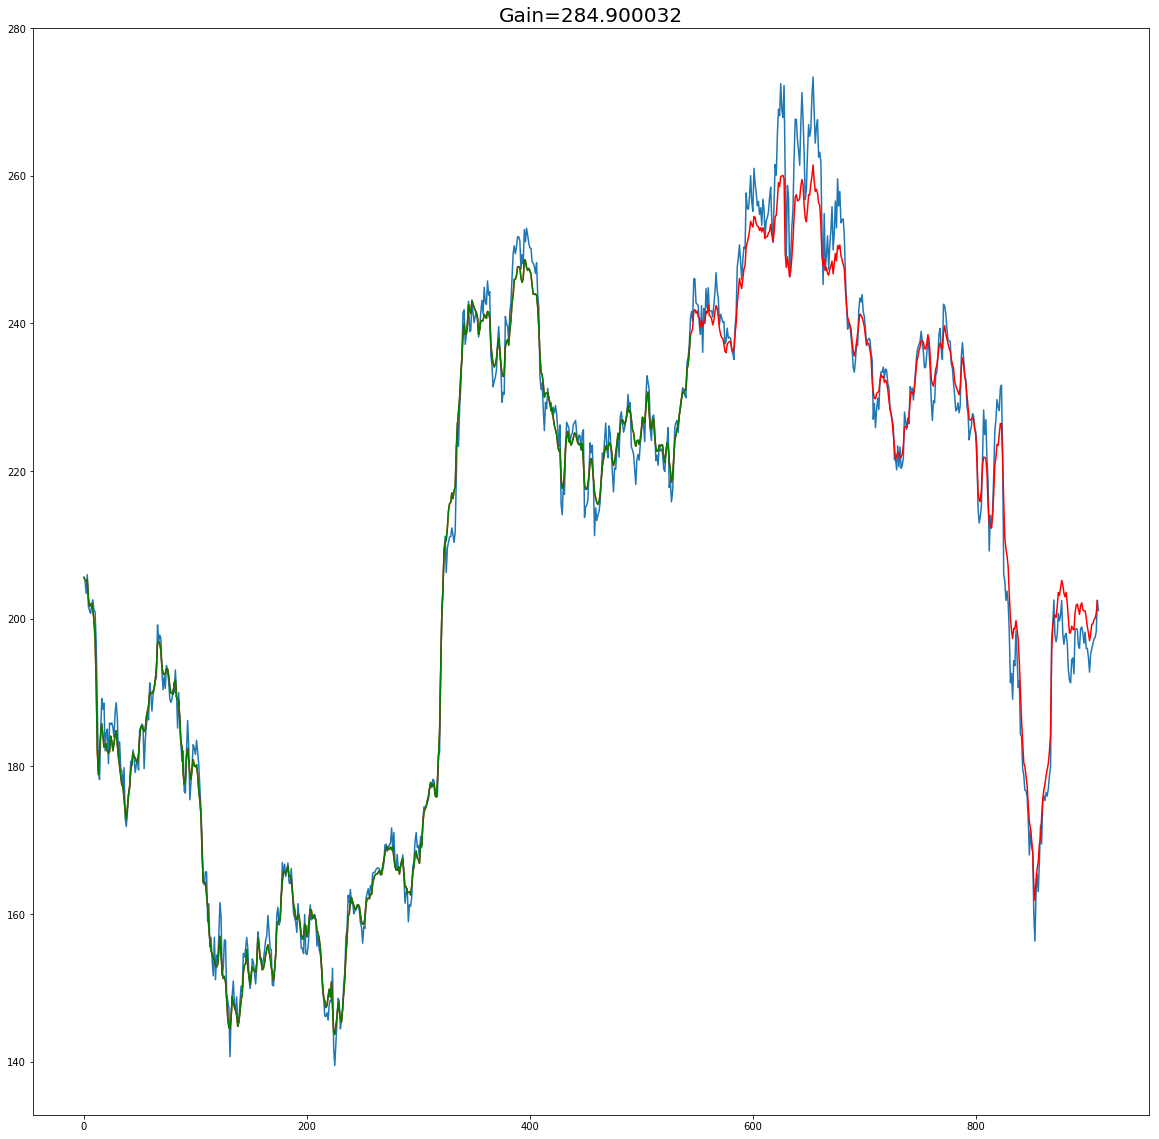

In [ ]:
prices=prices.rename(columns={'GS_Close':'GS_Close(t)'})

actual=prices["GS_Close(t)"][len(prices)-len(Xtest_f):]
use=prices["GS_Close(t)"][len(prices)-len(Xtest_f)-1:]

plt.figure(figsize=(20,20))
plt.plot(prices['GS_Close(t)'])

plt.plot(all_predictions_mem,'r')
plt.plot(trainPredict_mem,'g')
plt.title('Gain={}'.format(np.sum(gainz(testPredict_mem,actual,use))),size=20)

# Adding Dropout

In [ ]:
Xtrain_f,ytrain_f,Xtest_f,ytest_f,scaler_x_f,scaler_y_f=transform_features(prices)

model_lstm = tensorflow.keras.models.Sequential()
model_lstm.add(layers.LSTM(50, input_shape=(Xtrain_f.shape[1], Xtrain_f.shape[2])))
model_lstm.add(layers.Dropout(0.2))
model_lstm.add(layers.Dense(1))
opt=tensorflow.keras.optimizers.Adam(lr=0.01,epsilon=None,decay=0)
model_lstm.compile(loss='mse', optimizer=opt)

earlyStopping =EarlyStopping(monitor='val_loss', patience=50, verbose=0, mode='min')
mcp_save = ModelCheckpoint('simple_lstm_7.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=70, verbose=1,min_delta=0.001, mode='min')

model_lstm.fit(Xtrain_f,ytrain_f, epochs=60, batch_size=20, validation_data=(Xtest_f,ytest_f),verbose=1,callbacks=[earlyStopping, mcp_save, reduce_lr_loss])

trainPredict_f=model_lstm.predict(Xtrain_f)
testPredict_f= model_lstm.predict(Xtest_f)

all_predictions_f=[]
trainPredict_f=scaler_y_f.inverse_transform(trainPredict_f)
testPredict_f=scaler_y_f.inverse_transform(testPredict_f)
all_predictions_f=np.append(trainPredict_f,testPredict_f)

Train on 545 samples, validate on 365 samples
Epoch 1/60
545/545 [==============================] - 24s 44ms/step - loss: 0.0381 - val_loss: 0.0229
Epoch 2/60
545/545 [==============================] - 0s 763us/step - loss: 0.0066 - val_loss: 0.0129
Epoch 3/60
545/545 [==============================] - 0s 518us/step - loss: 0.0049 - val_loss: 0.0096
Epoch 4/60
545/545 [==============================] - 0s 511us/step - loss: 0.0039 - val_loss: 0.0078
Epoch 5/60
545/545 [==============================] - 0s 282us/step - loss: 0.0032 - val_loss: 0.0094
Epoch 6/60
545/545 [==============================] - 0s 481us/step - loss: 0.0030 - val_loss: 0.0030
Epoch 7/60
545/545 [==============================] - 0s 258us/step - loss: 0.0026 - val_loss: 0.0080
Epoch 8/60
545/545 [==============================] - 0s 496us/step - loss: 0.0035 - val_loss: 0.0018
Epoch 9/60
545/545 [==============================] - 0s 300us/step - loss: 0.0033 - val_loss: 0.0041
Epoch 10/60
545/545 [===============

Text(0.5, 1.0, 'Gain=423.64009599999986')

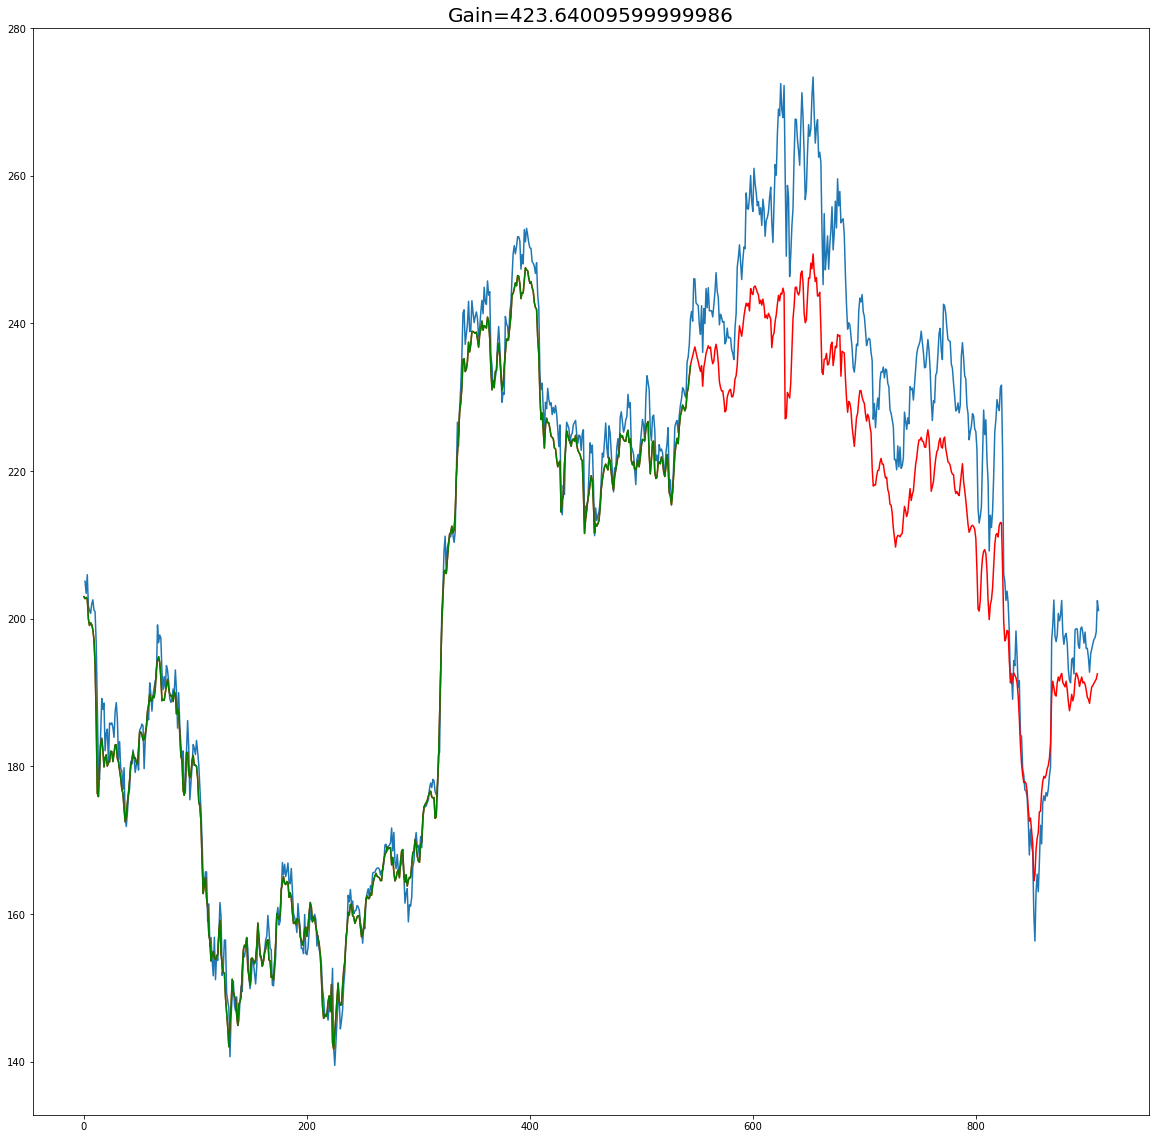

In [ ]:
prices=prices.rename(columns={'GS_Close':'GS_Close(t)'})
actual=prices["GS_Close(t)"][len(prices)-len(Xtest_f):]
use=prices["GS_Close(t)"][len(prices)-len(Xtest_f)-1:]

plt.figure(figsize=(20,20))
plt.plot(prices['GS_Close(t)'])

plt.plot(all_predictions_f,'r')
plt.plot(trainPredict_f,'g')
plt.title('Gain={}'.format(np.sum(gainz(testPredict_f,actual,use))),size=20)

# Stacked LSTM

### Stacked LSTM & passing data as features

In [ ]:
Xtrain_f,ytrain_f,Xtest_f,ytest_f,scaler_x_f,scaler_y_f=transform_features(prices)

model_lstm = tensorflow.keras.models.Sequential()
model_lstm.add(layers.LSTM(50, input_shape=(Xtrain_f.shape[1], Xtrain_f.shape[2]),return_sequences=True))
model_lstm.add(layers.LSTM(30, input_shape=(Xtrain_f.shape[1], Xtrain_f.shape[2])))
model_lstm.add(layers.Dense(1))
opt=tensorflow.keras.optimizers.Adam(lr=0.01,epsilon=None,decay=0)
model_lstm.compile(loss='mse', optimizer=opt)
earlyStopping =EarlyStopping(monitor='val_loss', patience=80, verbose=0, mode='min')
mcp_save = ModelCheckpoint('simple_lstm_8.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=70, verbose=1,min_delta=0.00001, mode='min')

model_lstm.fit(Xtrain_f,ytrain_f, epochs=150, batch_size=20, validation_data=(Xtest_f, ytest_f),verbose=1,callbacks=[earlyStopping, mcp_save, reduce_lr_loss])

trainPredict_f=model_lstm.predict(Xtrain_f)
testPredict_f= model_lstm.predict(Xtest_f)

all_predictions_f=[]
trainPredict_f=scaler_y_f.inverse_transform(trainPredict_f)
testPredict_f=scaler_y_f.inverse_transform(testPredict_f)
all_predictions_f=np.append(trainPredict_f,testPredict_f)


Train on 545 samples, validate on 365 samples
Epoch 1/150
545/545 [==============================] - 27s 49ms/step - loss: 0.0438 - val_loss: 0.0111
Epoch 2/150
545/545 [==============================] - 0s 908us/step - loss: 0.0028 - val_loss: 0.0078
Epoch 3/150
545/545 [==============================] - 0s 578us/step - loss: 0.0013 - val_loss: 0.0048
Epoch 4/150
545/545 [==============================] - 0s 642us/step - loss: 8.3877e-04 - val_loss: 0.0030
Epoch 5/150
545/545 [==============================] - 0s 736us/step - loss: 7.4327e-04 - val_loss: 0.0027
Epoch 6/150
545/545 [==============================] - 0s 373us/step - loss: 6.8905e-04 - val_loss: 0.0042
Epoch 7/150
545/545 [==============================] - 0s 357us/step - loss: 7.0391e-04 - val_loss: 0.0033
Epoch 8/150
545/545 [==============================] - 1s 930us/step - loss: 6.2922e-04 - val_loss: 0.0015
Epoch 9/150
545/545 [==============================] - 0s 591us/step - loss: 8.5875e-04 - val_loss: 0.0012
Epo

Text(0.5, 1.0, 'Gain=550.5599539999995')

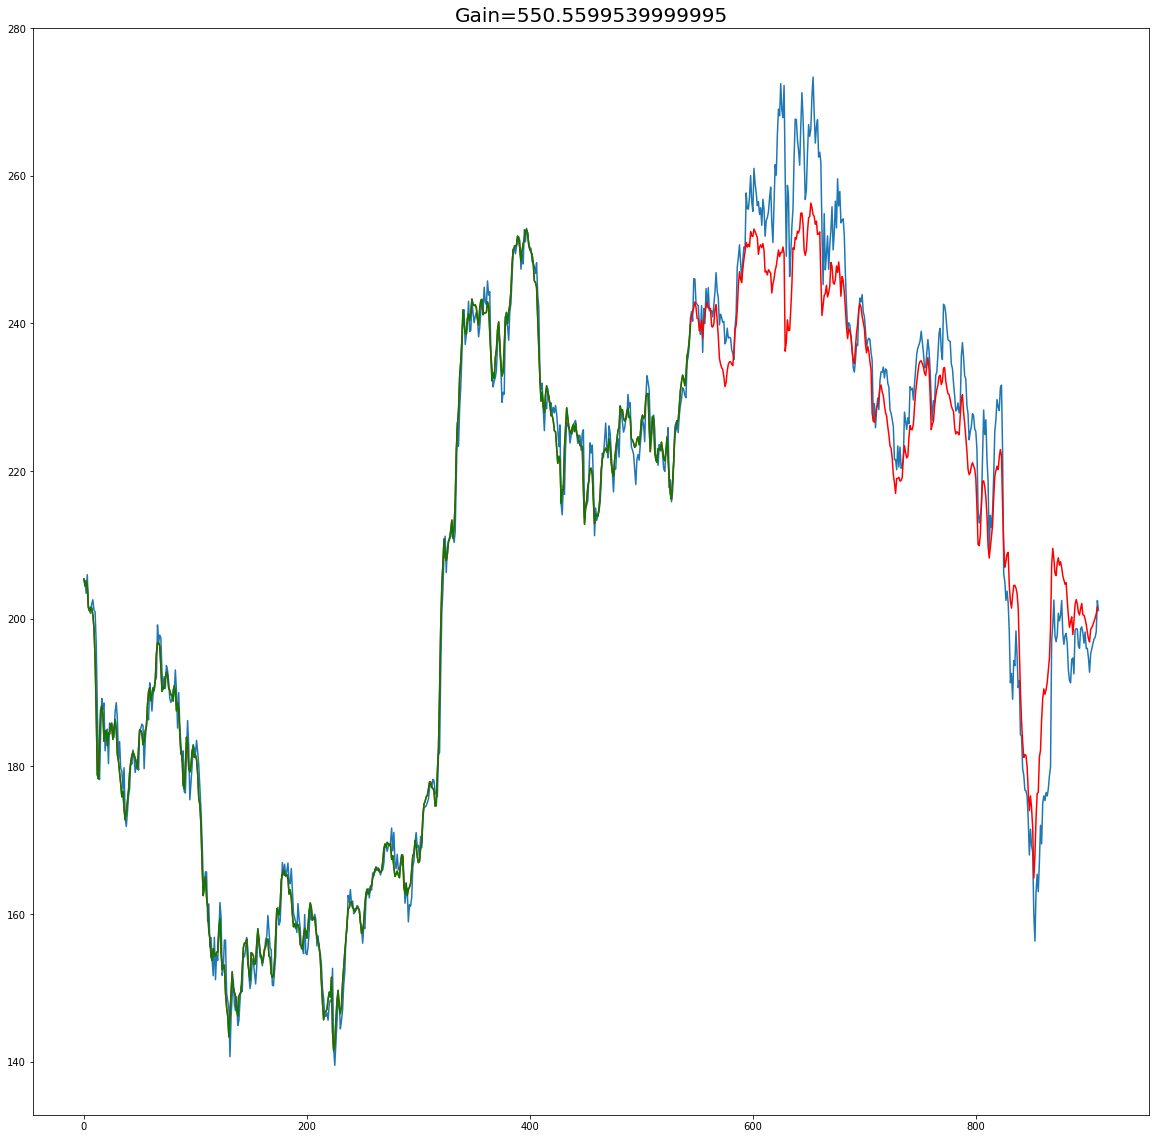

In [ ]:
prices=prices.rename(columns={'GS_Close':'GS_Close(t)'})
actual=prices["GS_Close(t)"][len(prices)-len(Xtest_f):]
use=prices["GS_Close(t)"][len(prices)-len(Xtest_f)-1:]

plt.figure(figsize=(20,20))
plt.plot(prices['GS_Close(t)'])

plt.plot(all_predictions_f,'r')
plt.plot(trainPredict_f,'g')
plt.title('Gain={}'.format(np.sum(gainz(testPredict_f,actual,use))),size=20)

### Stacked LSTM & passing data as timesteps

In [ ]:
Xtrain_t,ytrain_t,Xtest_t,ytest_t,scaler_x_t,scaler_y_t=transform_features(prices)

model_lstm = tensorflow.keras.models.Sequential()
model_lstm.add(layers.LSTM(50, input_shape=(Xtrain_t.shape[1], Xtrain_t.shape[2]),return_sequences=True))
model_lstm.add(layers.LSTM(30, input_shape=(Xtrain_t.shape[1], Xtrain_t.shape[2])))
model_lstm.add(layers.Dense(1))
opt=tensorflow.keras.optimizers.Adam(lr=0.01,epsilon=None,decay=0)
model_lstm.compile(loss='mse', optimizer=opt)
earlyStopping =EarlyStopping(monitor='val_loss', patience=50, verbose=0, mode='min')
mcp_save = ModelCheckpoint('simple_lstm_9.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=70, verbose=1,min_delta=0.00001, mode='min')

model_lstm.fit(Xtrain_t,ytrain_t, epochs=150, batch_size=20, validation_data=(Xtest_t, ytest_t),verbose=1,callbacks=[earlyStopping, mcp_save, reduce_lr_loss])

trainPredict_t=model_lstm.predict(Xtrain_t)
testPredict_t= model_lstm.predict(Xtest_t)

all_predictions_t=[]
trainPredict_t=scaler_y_t.inverse_transform(trainPredict_t)
testPredict_t=scaler_y_t.inverse_transform(testPredict_t)
all_predictions_t=np.append(trainPredict_t,testPredict_t)


Train on 545 samples, validate on 365 samples
Epoch 1/150
545/545 [==============================] - 3s 5ms/step - loss: 0.0354 - val_loss: 0.0075
Epoch 2/150
545/545 [==============================] - 0s 526us/step - loss: 0.0020 - val_loss: 0.0056
Epoch 3/150
545/545 [==============================] - 0s 432us/step - loss: 0.0011 - val_loss: 0.0027
Epoch 4/150
545/545 [==============================] - 0s 444us/step - loss: 8.2519e-04 - val_loss: 0.0024
Epoch 5/150
545/545 [==============================] - 0s 482us/step - loss: 0.0011 - val_loss: 0.0020
Epoch 6/150
545/545 [==============================] - 0s 406us/step - loss: 6.7061e-04 - val_loss: 0.0013
Epoch 7/150
545/545 [==============================] - 0s 338us/step - loss: 7.8459e-04 - val_loss: 0.0023
Epoch 8/150
545/545 [==============================] - 0s 361us/step - loss: 6.8636e-04 - val_loss: 0.0021
Epoch 9/150
545/545 [==============================] - 0s 336us/step - loss: 5.7086e-04 - val_loss: 0.0034
Epoch 10/

In [ ]:
model_lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 50)             16000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 30)                9720      
_________________________________________________________________
dense (Dense)                (None, 1)                 31        
Total params: 25,751
Trainable params: 25,751
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 1.0, 'Gain=566.2199299999997')

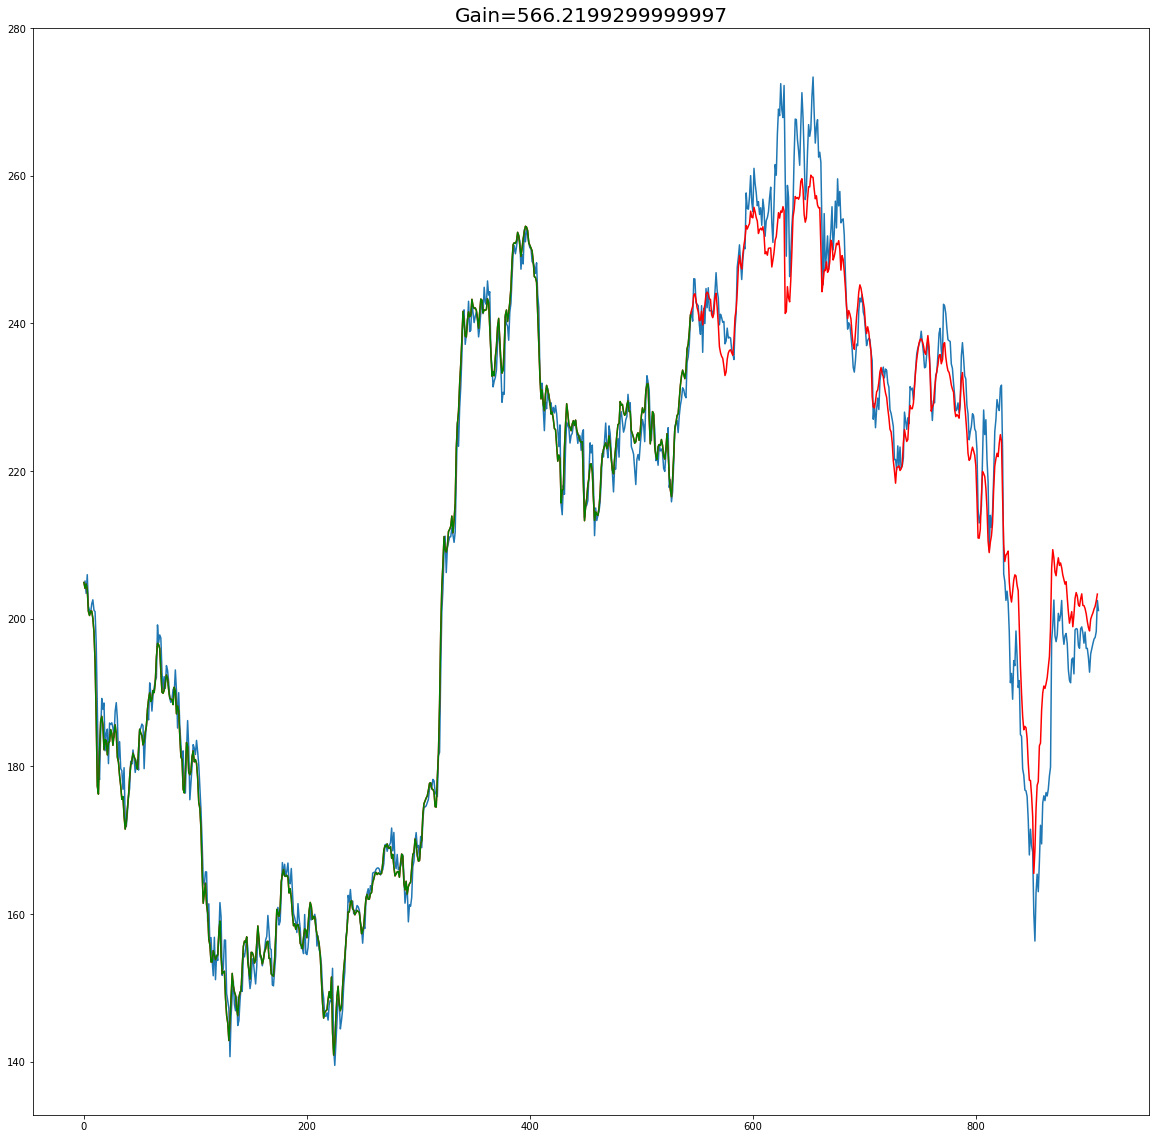

In [ ]:
prices=prices.rename(columns={'GS_Close':'GS_Close(t)'})
actual=prices["GS_Close(t)"][len(prices)-len(Xtest_t):]
use=prices["GS_Close(t)"][len(prices)-len(Xtest_t)-1:]

plt.figure(figsize=(20,20))
plt.plot(prices['GS_Close(t)'])

plt.plot(all_predictions_t,'r')
plt.plot(trainPredict_t,'g')
plt.title('Gain={}'.format(np.sum(gainz(testPredict_t,actual,use))),size=20)

### Stacked LSTM with memory between batches

In [ ]:
Xtrain_f,ytrain_f,Xtest_f,ytest_f,scaler_x_f,scaler_y_f=transform_features(prices)

model_lstm = tensorflow.keras.models.Sequential()
model_lstm.add(layers.LSTM(50, input_shape=(Xtrain_f.shape[1], Xtrain_f.shape[2]),return_sequences=True))
model_lstm.add(layers.LSTM(30, input_shape=(Xtrain_f.shape[1], Xtrain_f.shape[2])))
model_lstm.add(layers.Dense(1))
opt=tensorflow.keras.optimizers.Adam(lr=0.01,epsilon=None,decay=0)
model_lstm.compile(loss='mse', optimizer=opt)
for i in range(100):
    model_lstm.fit(Xtrain_f,ytrain_f, epochs=1, batch_size=20, validation_data=(Xtest_f,ytest_f),verbose=1,shuffle=False)
    model_lstm.reset_states()
    
trainPredict_mem=model_lstm.predict(Xtrain_f)
model_lstm.reset_states()
testPredict_mem= model_lstm.predict(Xtest_f)

all_predictions_mem=[]
trainPredict_mem=scaler_y_f.inverse_transform(trainPredict_mem)
testPredict_mem=scaler_y_f.inverse_transform(testPredict_mem)
all_predictions_mem=np.append(trainPredict_mem,testPredict_mem)


Train on 545 samples, validate on 365 samples
Epoch 1/1
545/545 [==============================] - 16s 29ms/step - loss: 0.0542 - val_loss: 0.0519
Train on 545 samples, validate on 365 samples
Epoch 1/1
545/545 [==============================] - 0s 373us/step - loss: 0.0698 - val_loss: 0.0603
Train on 545 samples, validate on 365 samples
Epoch 1/1
545/545 [==============================] - 0s 359us/step - loss: 0.0875 - val_loss: 0.0424
Train on 545 samples, validate on 365 samples
Epoch 1/1
545/545 [==============================] - 0s 361us/step - loss: 0.0338 - val_loss: 0.0287
Train on 545 samples, validate on 365 samples
Epoch 1/1
545/545 [==============================] - 0s 406us/step - loss: 0.0070 - val_loss: 0.0153
Train on 545 samples, validate on 365 samples
Epoch 1/1
545/545 [==============================] - 0s 350us/step - loss: 0.0048 - val_loss: 0.0086
Train on 545 samples, validate on 365 samples
Epoch 1/1
545/545 [==============================] - 0s 348us/step - los

Text(0.5, 1.0, 'Gain=139.800342')

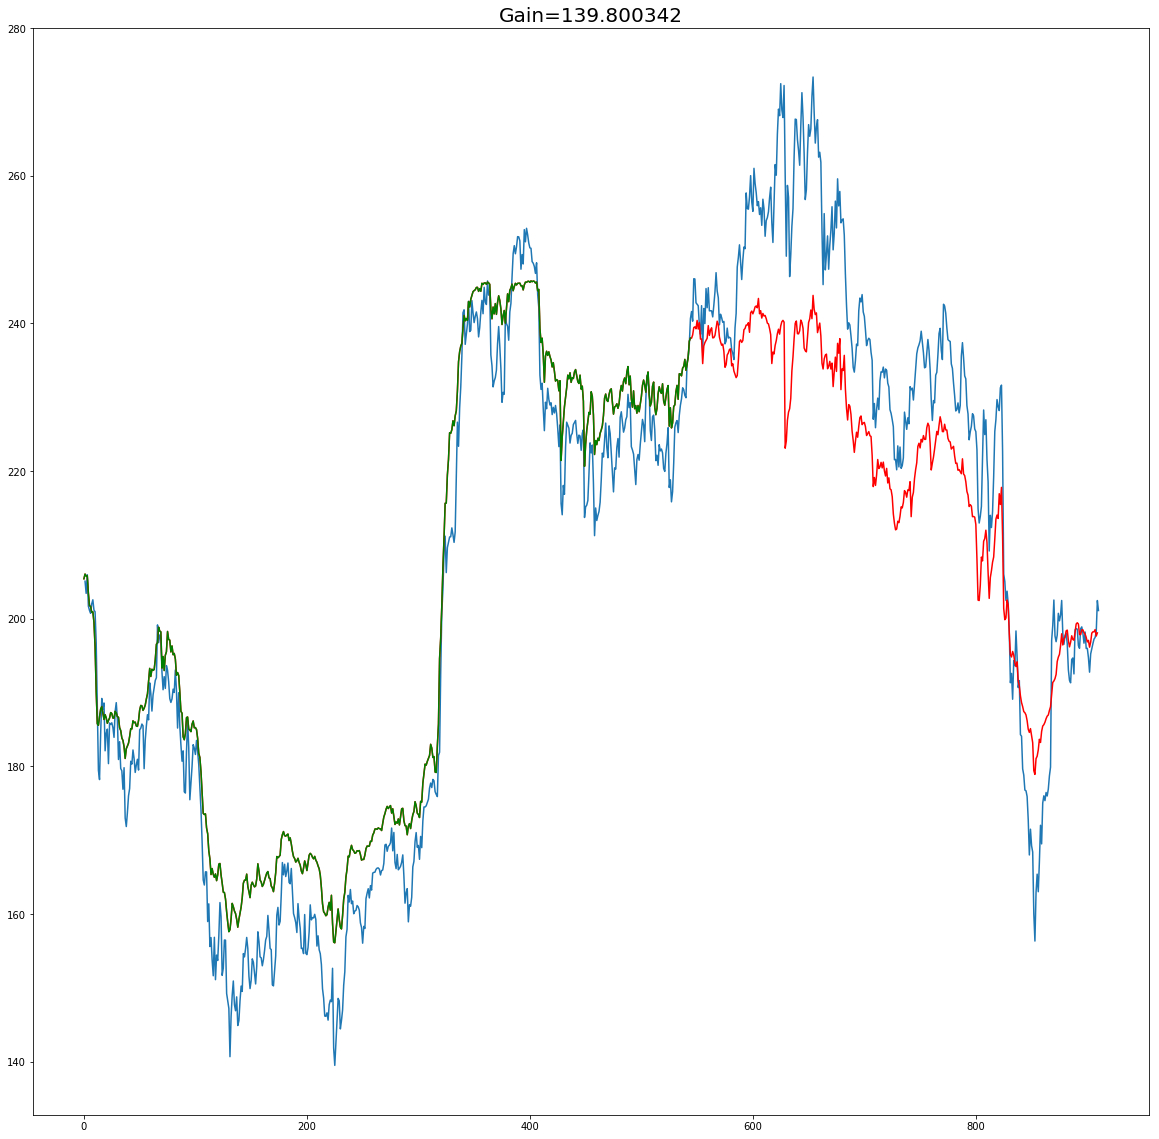

In [ ]:
prices=prices.rename(columns={'GS_Close':'GS_Close(t)'})
actual=prices["GS_Close(t)"][len(prices)-len(Xtest_f):]
use=prices["GS_Close(t)"][len(prices)-len(Xtest_f)-1:]

plt.figure(figsize=(20,20))
plt.plot(prices['GS_Close(t)'])

plt.plot(all_predictions_mem,'r')
plt.plot(trainPredict_mem,'g')
plt.title('Gain={}'.format(np.sum(gainz(testPredict_mem,actual,use))),size=20)

### Adding Dropout

In [ ]:
Xtrain_t,ytrain_t,Xtest_t,ytest_t,scaler_x_t,scaler_y_t=transform_features(prices)

model_lstm = tensorflow.keras.models.Sequential()
model_lstm.add(layers.LSTM(50, input_shape=(Xtrain_t.shape[1], Xtrain_t.shape[2]),return_sequences=True))
model_lstm.add(layers.Dropout(0.2))
model_lstm.add(layers.LSTM(30, input_shape=(Xtrain_t.shape[1], Xtrain_t.shape[2])))
model_lstm.add(layers.Dense(1))
opt=tensorflow.keras.optimizers.Adam(lr=0.01,epsilon=None,decay=0)
model_lstm.compile(loss='mse', optimizer=opt)
earlyStopping =EarlyStopping(monitor='val_loss', patience=50, verbose=0, mode='min')
mcp_save = ModelCheckpoint('simple_lstm_10.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=70, verbose=1,min_delta=0.00001, mode='min')

model_lstm.fit(Xtrain_t,ytrain_t, epochs=150, batch_size=20, validation_data=(Xtest_t, ytest_t),verbose=1,callbacks=[earlyStopping, mcp_save, reduce_lr_loss])

trainPredict_t=model_lstm.predict(Xtrain_t)
testPredict_t= model_lstm.predict(Xtest_t)

all_predictions_t=[]
trainPredict_t=scaler_y_t.inverse_transform(trainPredict_t)
testPredict_t=scaler_y_t.inverse_transform(testPredict_t)
all_predictions_t=np.append(trainPredict_t,testPredict_t)


Train on 545 samples, validate on 365 samples
Epoch 1/150
545/545 [==============================] - 34s 63ms/step - loss: 0.0420 - val_loss: 0.0118
Epoch 2/150
545/545 [==============================] - 0s 467us/step - loss: 0.0047 - val_loss: 0.0125
Epoch 3/150
545/545 [==============================] - 1s 953us/step - loss: 0.0031 - val_loss: 0.0104
Epoch 4/150
545/545 [==============================] - 0s 707us/step - loss: 0.0023 - val_loss: 0.0059
Epoch 5/150
545/545 [==============================] - 0s 716us/step - loss: 0.0022 - val_loss: 0.0052
Epoch 6/150
545/545 [==============================] - 0s 434us/step - loss: 0.0019 - val_loss: 0.0068
Epoch 7/150
545/545 [==============================] - 0s 858us/step - loss: 0.0025 - val_loss: 0.0047
Epoch 8/150
545/545 [==============================] - 0s 432us/step - loss: 0.0020 - val_loss: 0.0071
Epoch 9/150
545/545 [==============================] - 0s 437us/step - loss: 0.0024 - val_loss: 0.0076
Epoch 10/150
545/545 [=====

Text(0.5, 1.0, 'Gain=405.70000999999985')

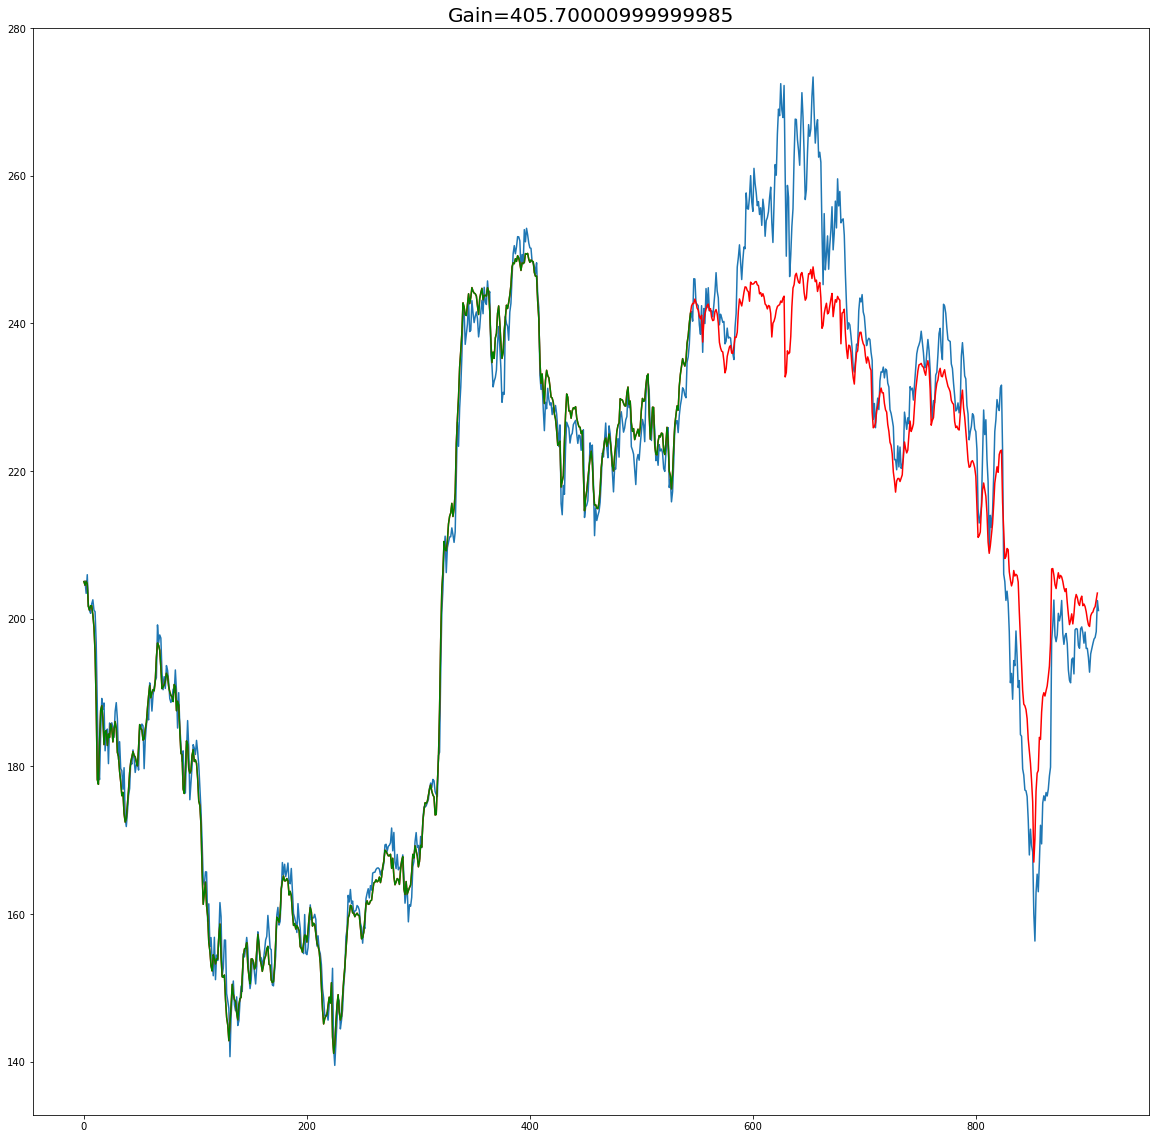

In [ ]:
prices=prices.rename(columns={'GS_Close':'GS_Close(t)'})
actual=prices["GS_Close(t)"][len(prices)-len(Xtest_t):]
use=prices["GS_Close(t)"][len(prices)-len(Xtest_t)-1:]

plt.figure(figsize=(20,20))
plt.plot(prices['GS_Close(t)'])

plt.plot(all_predictions_t,'r')
plt.plot(trainPredict_t,'g')
plt.title('Gain={}'.format(np.sum(gainz(testPredict_t,actual,use))),size=20)

# Importance of our data

### Try make a model with the help of XGBoost

In [ ]:
def get_feature_importance_data(data_income):
    data = data_income.copy()
    y = data['GS_Close(t)']
    X = data.iloc[:, 1:]
    
    train_samples = int(X.shape[0] * 0.65)
 
    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]
    
    return (X_train, y_train), (X_test, y_test)

In [ ]:
(X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = get_feature_importance_data(prices)

In [ ]:
regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=150,base_score=0.7,colsample_bytree=1,learning_rate=0.05)

In [ ]:
xgbModel = regressor.fit(X_train_FI,y_train_FI, \
                         eval_set = [(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)], \
                         verbose=False)

In [ ]:
eval_result = regressor.evals_result()

In [ ]:
training_rounds = range(len(eval_result['validation_0']['rmse']))

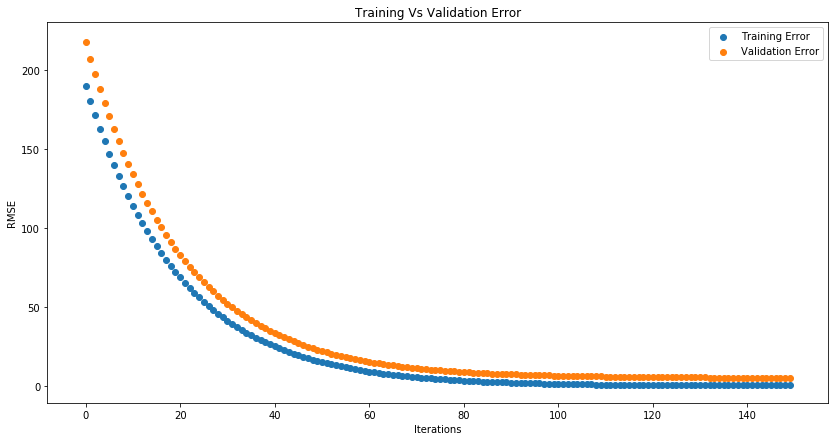

In [ ]:
fig = plt.figure(figsize=(14,7))

plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

[0.03678866 0.04233235 0.03820048 0.03767892 0.04636089 0.03669113
 0.0369128  0.03927601 0.03737784 0.03552355 0.03620506 0.03550418
 0.03681748 0.03749193 0.03592286 0.03498562 0.03414714 0.03490919
 0.03455951 0.03558455 0.03614293 0.03616881 0.03499078 0.03818502
 0.         0.         0.03818237 0.03573691 0.03732305]


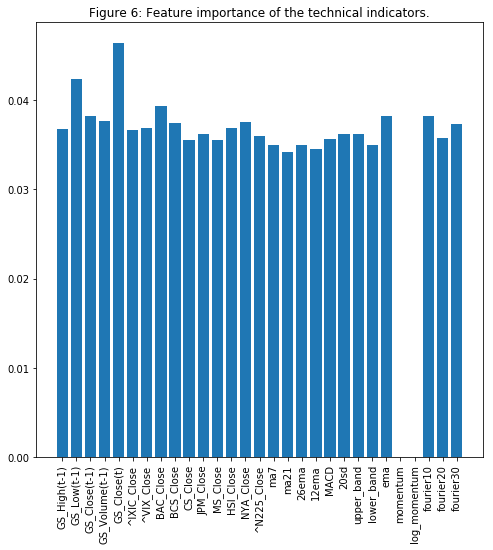

In [ ]:
# plot feature importance manually
from numpy import loadtxt
from xgboost import XGBClassifier

# fit model no training data
model = XGBClassifier()
model.fit(X_train_FI, y_train_FI)
# feature importance
print(model.feature_importances_)
# plot
fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(model.feature_importances_))], model.feature_importances_.tolist(), tick_label=X_test_FI.columns)
plt.title('Figure 6: Feature importance of the technical indicators.')
plt.show()


# (X_train_FI, y_train_FI), (X_test_FI, y_test_FI)

### And with PCA

In [ ]:
##### Since we can't figure out a better model from XGBoost we compress our dataset and follow the previous
##### process to try get better results

import numpy
from pandas import read_csv
from sklearn.decomposition import PCA

array = prices.T.values
X = array[:-1,:]
array = prices.values
Y = array[:,-1]
# feature extraction
pca = PCA(n_components=5)
fit = pca.fit(X)
# summarize components
print(fit.components_)

[[ 0.01357887  0.01313886  0.01495687 ...  0.01310475  0.0264133
   0.02968705]
 [ 0.05555427  0.05603052  0.05338694 ...  0.06831714  0.05138809
   0.04731021]
 [ 0.02181332  0.02085692  0.01836902 ...  0.02516221  0.00363885
  -0.00150888]
 [-0.08598259 -0.06054162 -0.06520402 ...  0.02732242  0.03475158
   0.03637584]
 [-0.0245339  -0.03543764 -0.02701038 ...  0.05069916  0.05796415
   0.05887006]]


# Prediction Model From PCA dataset

In [ ]:
prices_2=pd.DataFrame(fit.components_)
prices_2=prices_2.T
prices_2['GS_Close(t)']=Y

### Simple LSTM & passing data as features

In [ ]:
Xtrain_f,ytrain_f,Xtest_f,ytest_f,scaler_x_f,scaler_y_f=transform_features(prices_2)

model_lstm = tensorflow.keras.models.Sequential()
model_lstm.add(layers.LSTM(50, input_shape=(Xtrain_f.shape[1], Xtrain_f.shape[2])))
model_lstm.add(layers.Dense(1))
opt=tensorflow.keras.optimizers.Adam(lr=0.01,epsilon=None,decay=0)
model_lstm.compile(loss='mse', optimizer=opt)

earlyStopping =EarlyStopping(monitor='val_loss', patience=50, verbose=0, mode='min')
mcp_save = ModelCheckpoint('simple_lstm_11.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=70, verbose=1,min_delta=0.001, mode='min')

model_lstm.fit(Xtrain_f,ytrain_f, epochs=60, batch_size=20, validation_data=(Xtest_f,ytest_f),verbose=1,callbacks=[earlyStopping, mcp_save, reduce_lr_loss])

trainPredict_f=model_lstm.predict(Xtrain_f)
testPredict_f= model_lstm.predict(Xtest_f)

all_predictions_f=[]
trainPredict_f=scaler_y_f.inverse_transform(trainPredict_f)
testPredict_f=scaler_y_f.inverse_transform(testPredict_f)
all_predictions_f=np.append(trainPredict_f,testPredict_f)


Train on 545 samples, validate on 365 samples
Epoch 1/60
545/545 [==============================] - 30s 55ms/step - loss: 0.0922 - val_loss: 0.0893
Epoch 2/60
545/545 [==============================] - 0s 340us/step - loss: 0.0740 - val_loss: 0.1188
Epoch 3/60
545/545 [==============================] - 0s 675us/step - loss: 0.0668 - val_loss: 0.0842
Epoch 4/60
545/545 [==============================] - 0s 337us/step - loss: 0.0650 - val_loss: 0.1090
Epoch 5/60
545/545 [==============================] - 0s 320us/step - loss: 0.0584 - val_loss: 0.1946
Epoch 6/60
545/545 [==============================] - 0s 302us/step - loss: 0.0561 - val_loss: 0.1925
Epoch 7/60
545/545 [==============================] - 0s 306us/step - loss: 0.0586 - val_loss: 0.3018
Epoch 8/60
545/545 [==============================] - 0s 306us/step - loss: 0.0600 - val_loss: 0.1971
Epoch 9/60
545/545 [==============================] - 0s 309us/step - loss: 0.0610 - val_loss: 0.1445
Epoch 10/60
545/545 [===============

Text(0.5, 1.0, 'Gain=367.00012400000026')

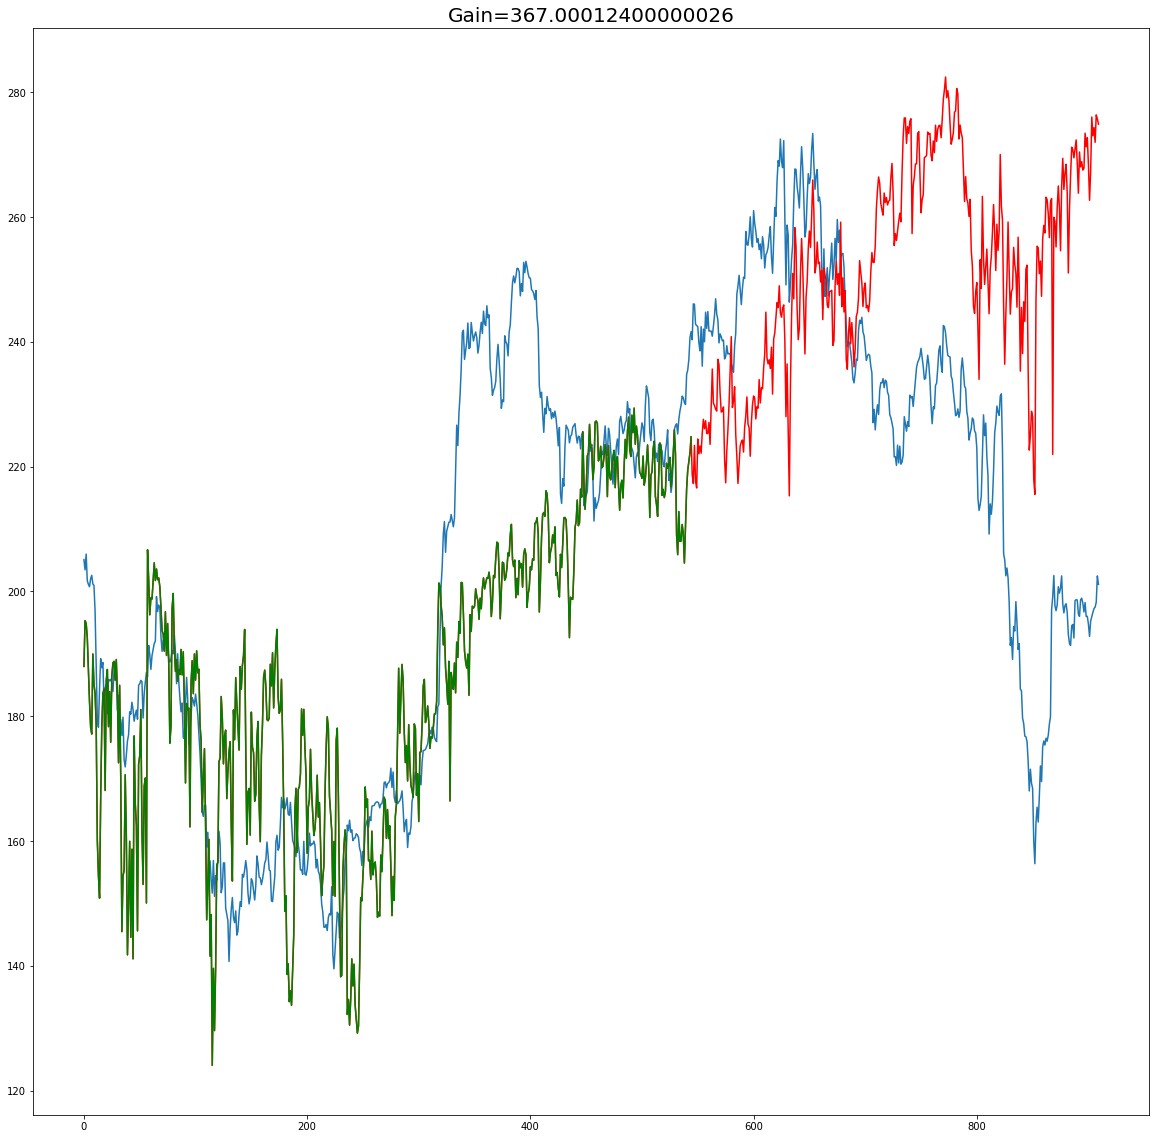

In [ ]:
prices_2=prices_2.rename(columns={'GS_Close':'GS_Close(t)'})
actual=prices_2["GS_Close(t)"][len(prices_2)-len(Xtest_f):]
use=prices_2["GS_Close(t)"][len(prices_2)-len(Xtest_f)-1:]

plt.figure(figsize=(20,20))
plt.plot(prices_2['GS_Close(t)'])

plt.plot(all_predictions_f,'r')
plt.plot(trainPredict_f,'g')
plt.title('Gain={}'.format(np.sum(gainz(testPredict_f,actual,use))),size=20)

### Simple LSTM & passing data as timesteps

In [ ]:
Xtrain_t,ytrain_t,Xtest_t,ytest_t,scaler_x_t,scaler_y_t=transform_timesteps(prices_2)

model_lstm = tensorflow.keras.models.Sequential()
model_lstm.add(layers.LSTM(80, input_shape=(Xtrain_t.shape[1], Xtrain_t.shape[2])))
model_lstm.add(layers.Dense(1))
opt=tensorflow.keras.optimizers.Adam(lr=0.01,epsilon=None,decay=0)
model_lstm.compile(loss='mse', optimizer=opt)

earlyStopping =EarlyStopping(monitor='val_loss', patience=50, verbose=0, mode='min')
mcp_save = ModelCheckpoint('simple_lstm_12.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=70, verbose=1,min_delta=0.0001, mode='min')

model_lstm.fit(Xtrain_t,ytrain_t, epochs=100, batch_size=20, validation_data=(Xtest_t, ytest_t),verbose=1,callbacks=[earlyStopping, mcp_save, reduce_lr_loss])

trainPredict_t=model_lstm.predict(Xtrain_t)
testPredict_t= model_lstm.predict(Xtest_t)

all_predictions_t=[]
trainPredict_t=scaler_y_t.inverse_transform(trainPredict_t)
testPredict_t=scaler_y_t.inverse_transform(testPredict_t)
all_predictions_t=np.append(trainPredict_t,testPredict_t)

Train on 545 samples, validate on 365 samples
Epoch 1/100
545/545 [==============================] - 32s 59ms/step - loss: 0.1066 - val_loss: 0.1736
Epoch 2/100
545/545 [==============================] - 1s 2ms/step - loss: 0.0781 - val_loss: 0.0793
Epoch 3/100
545/545 [==============================] - 1s 2ms/step - loss: 0.0774 - val_loss: 0.1344
Epoch 4/100
545/545 [==============================] - 1s 2ms/step - loss: 0.0733 - val_loss: 0.0915
Epoch 5/100
545/545 [==============================] - 1s 2ms/step - loss: 0.0717 - val_loss: 0.0862
Epoch 6/100
545/545 [==============================] - 1s 2ms/step - loss: 0.0644 - val_loss: 0.0875
Epoch 7/100
545/545 [==============================] - 1s 2ms/step - loss: 0.0621 - val_loss: 0.1607
Epoch 8/100
545/545 [==============================] - 1s 2ms/step - loss: 0.0599 - val_loss: 0.1834
Epoch 9/100
545/545 [==============================] - 1s 2ms/step - loss: 0.0539 - val_loss: 0.1500
Epoch 10/100
545/545 [=====================

Text(0.5, 1.0, 'Gain=111.14016399999986')

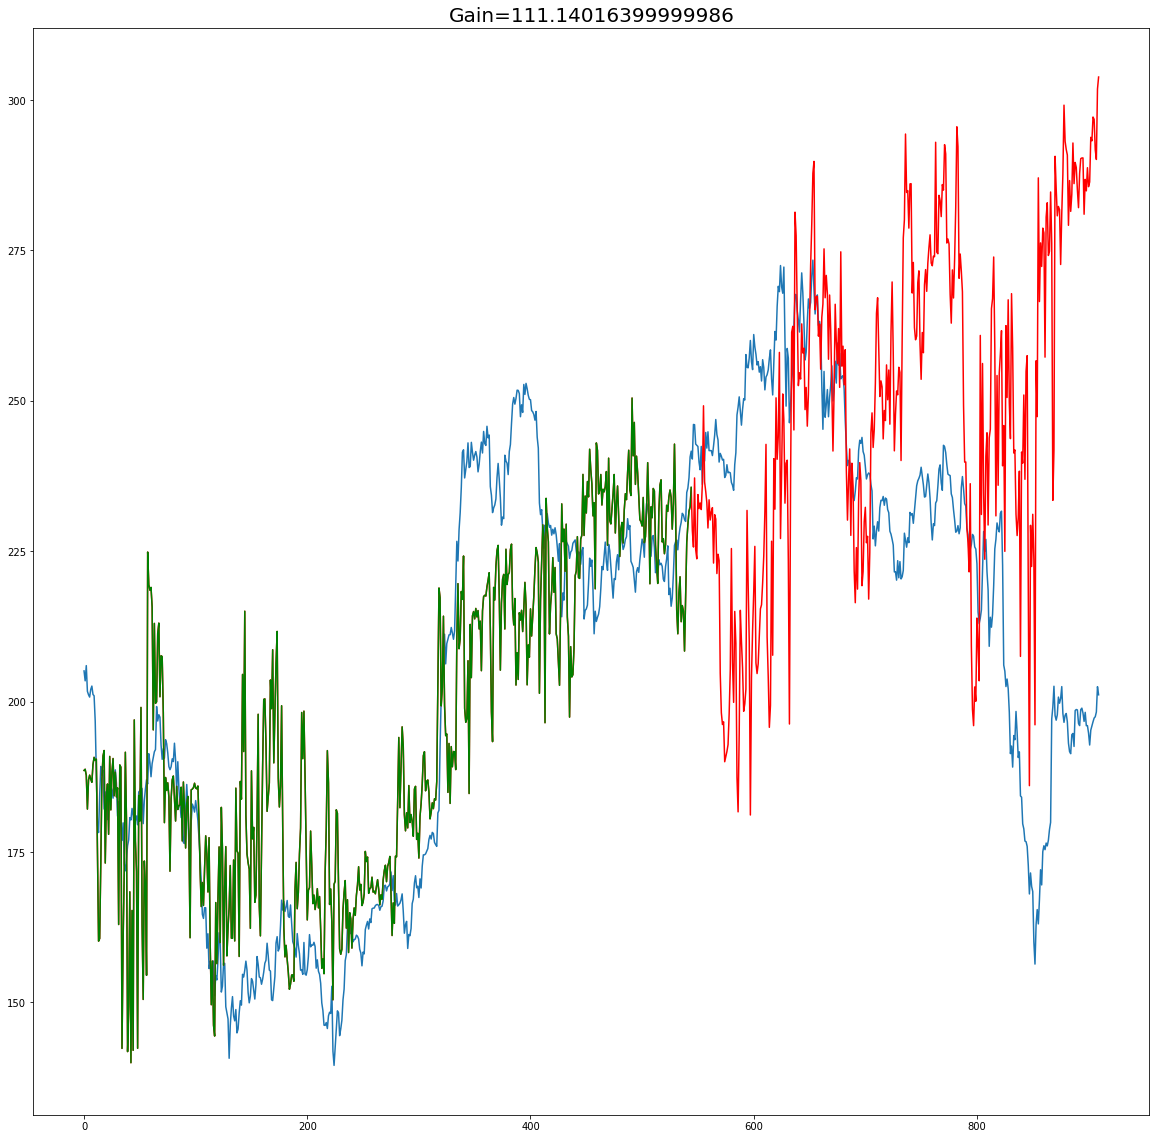

In [ ]:
prices_2=prices_2.rename(columns={'GS_Close':'GS_Close(t)'})
actual=prices_2["GS_Close(t)"][len(prices_2)-len(Xtest_f):]
use=prices_2["GS_Close(t)"][len(prices_2)-len(Xtest_f)-1:]

plt.figure(figsize=(20,20))
plt.plot(prices_2['GS_Close(t)'])

plt.plot(all_predictions_t,'r')
plt.plot(trainPredict_t,'g')
plt.title('Gain={}'.format(np.sum(gainz(testPredict_t,actual,use))),size=20)

### Simple LSTM with memory between batches

In [ ]:
Xtrain_f,ytrain_f,Xtest_f,ytest_f,scaler_x_f,scaler_y_f=transform_features(prices_2)

model_lstm = tensorflow.keras.models.Sequential()
model_lstm.add(layers.LSTM(50, input_shape=(Xtrain_f.shape[1], Xtrain_f.shape[2])))
model_lstm.add(layers.Dense(1))
opt=tensorflow.keras.optimizers.Adam(lr=0.001,epsilon=None,decay=0)
model_lstm.compile(loss='mse', optimizer=opt)
for i in range(50):
    model_lstm.fit(Xtrain_f,ytrain_f, epochs=1, batch_size=20, validation_data=(Xtest_f,ytest_f),verbose=1,shuffle=False)
    model_lstm.reset_states()
    
trainPredict_mem=model_lstm.predict(Xtrain_f)
model_lstm.reset_states()
testPredict_mem= model_lstm.predict(Xtest_f)

all_predictions_mem=[]
trainPredict_mem=scaler_y_f.inverse_transform(trainPredict_mem)
testPredict_mem=scaler_y_f.inverse_transform(testPredict_mem)
all_predictions_mem=np.append(trainPredict_mem,testPredict_mem)

Train on 545 samples, validate on 365 samples
Epoch 1/1
545/545 [==============================] - 19s 35ms/step - loss: 0.2197 - val_loss: 0.3547
Train on 545 samples, validate on 365 samples
Epoch 1/1
545/545 [==============================] - 0s 395us/step - loss: 0.0963 - val_loss: 0.1694
Train on 545 samples, validate on 365 samples
Epoch 1/1
545/545 [==============================] - 0s 392us/step - loss: 0.0841 - val_loss: 0.1218
Train on 545 samples, validate on 365 samples
Epoch 1/1
545/545 [==============================] - 0s 406us/step - loss: 0.0893 - val_loss: 0.1154
Train on 545 samples, validate on 365 samples
Epoch 1/1
545/545 [==============================] - 0s 467us/step - loss: 0.0896 - val_loss: 0.1143
Train on 545 samples, validate on 365 samples
Epoch 1/1
545/545 [==============================] - 0s 406us/step - loss: 0.0888 - val_loss: 0.1126
Train on 545 samples, validate on 365 samples
Epoch 1/1
545/545 [==============================] - 0s 341us/step - los

Text(0.5, 1.0, 'Gain=305.08012599999967')

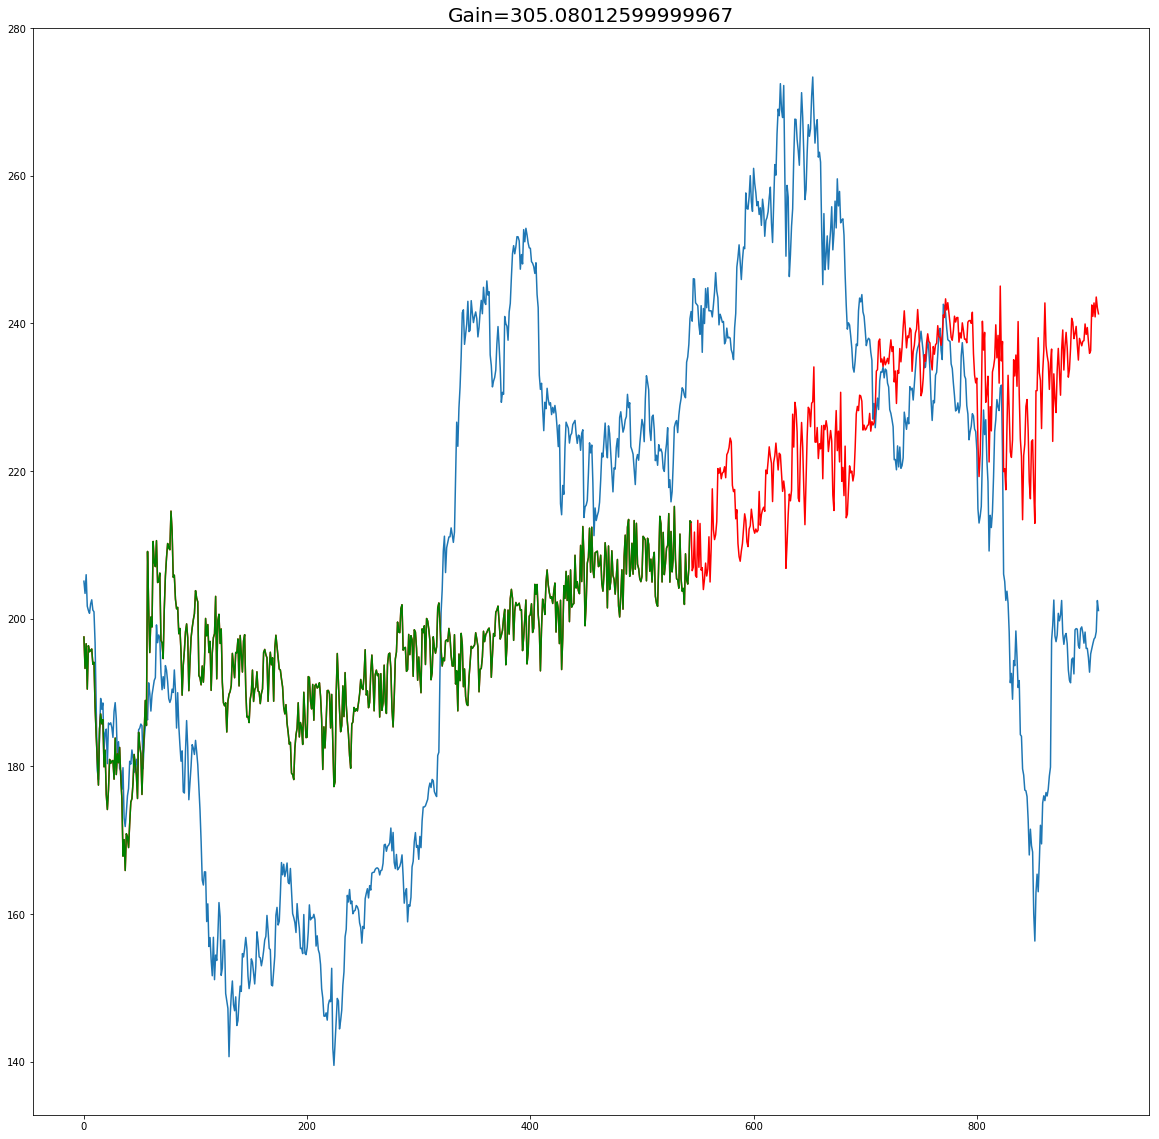

In [ ]:
prices_2=prices_2.rename(columns={'GS_Close':'GS_Close(t)'})

actual=prices_2["GS_Close(t)"][len(prices_2)-len(Xtest_f):]
use=prices_2["GS_Close(t)"][len(prices_2)-len(Xtest_f)-1:]

plt.figure(figsize=(20,20))
plt.plot(prices_2['GS_Close(t)'])

plt.plot(all_predictions_mem,'r')
plt.plot(trainPredict_mem,'g')
plt.title('Gain={}'.format(np.sum(gainz(testPredict_mem,actual,use))),size=20)

### Adding Dropout

In [ ]:
Xtrain_f,ytrain_f,Xtest_f,ytest_f,scaler_x_f,scaler_y_f=transform_features(prices_2)

model_lstm = tensorflow.keras.models.Sequential()
model_lstm.add(layers.LSTM(50, input_shape=(Xtrain_f.shape[1], Xtrain_f.shape[2])))
model_lstm.add(layers.Dropout(0.2))
model_lstm.add(layers.Dense(1))
opt=tensorflow.keras.optimizers.Adam(lr=0.01,epsilon=None,decay=0)
model_lstm.compile(loss='mse', optimizer=opt)

earlyStopping =EarlyStopping(monitor='val_loss', patience=50, verbose=0, mode='min')
mcp_save = ModelCheckpoint('simple_lstm_13.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=70, verbose=1,min_delta=0.001, mode='min')

model_lstm.fit(Xtrain_f,ytrain_f, epochs=60, batch_size=20, validation_data=(Xtest_f,ytest_f),verbose=1,callbacks=[earlyStopping, mcp_save, reduce_lr_loss])

trainPredict_f=model_lstm.predict(Xtrain_f)
testPredict_f= model_lstm.predict(Xtest_f)

all_predictions_f=[]
trainPredict_f=scaler_y_f.inverse_transform(trainPredict_f)
testPredict_f=scaler_y_f.inverse_transform(testPredict_f)
all_predictions_f=np.append(trainPredict_f,testPredict_f)


Train on 545 samples, validate on 365 samples
Epoch 1/60
545/545 [==============================] - 32s 59ms/step - loss: 0.0996 - val_loss: 0.0846
Epoch 2/60
545/545 [==============================] - 0s 388us/step - loss: 0.0756 - val_loss: 0.1046
Epoch 3/60
545/545 [==============================] - 0s 386us/step - loss: 0.0730 - val_loss: 0.0936
Epoch 4/60
545/545 [==============================] - 0s 686us/step - loss: 0.0765 - val_loss: 0.0837
Epoch 5/60
545/545 [==============================] - 0s 366us/step - loss: 0.0704 - val_loss: 0.1072
Epoch 6/60
545/545 [==============================] - 0s 362us/step - loss: 0.0624 - val_loss: 0.1144
Epoch 7/60
545/545 [==============================] - 0s 362us/step - loss: 0.0587 - val_loss: 0.1218
Epoch 8/60
545/545 [==============================] - 0s 351us/step - loss: 0.0671 - val_loss: 0.0938
Epoch 9/60
545/545 [==============================] - 0s 375us/step - loss: 0.0609 - val_loss: 0.1533
Epoch 10/60
545/545 [===============

Text(0.5, 1.0, 'Gain=413.2402040000001')

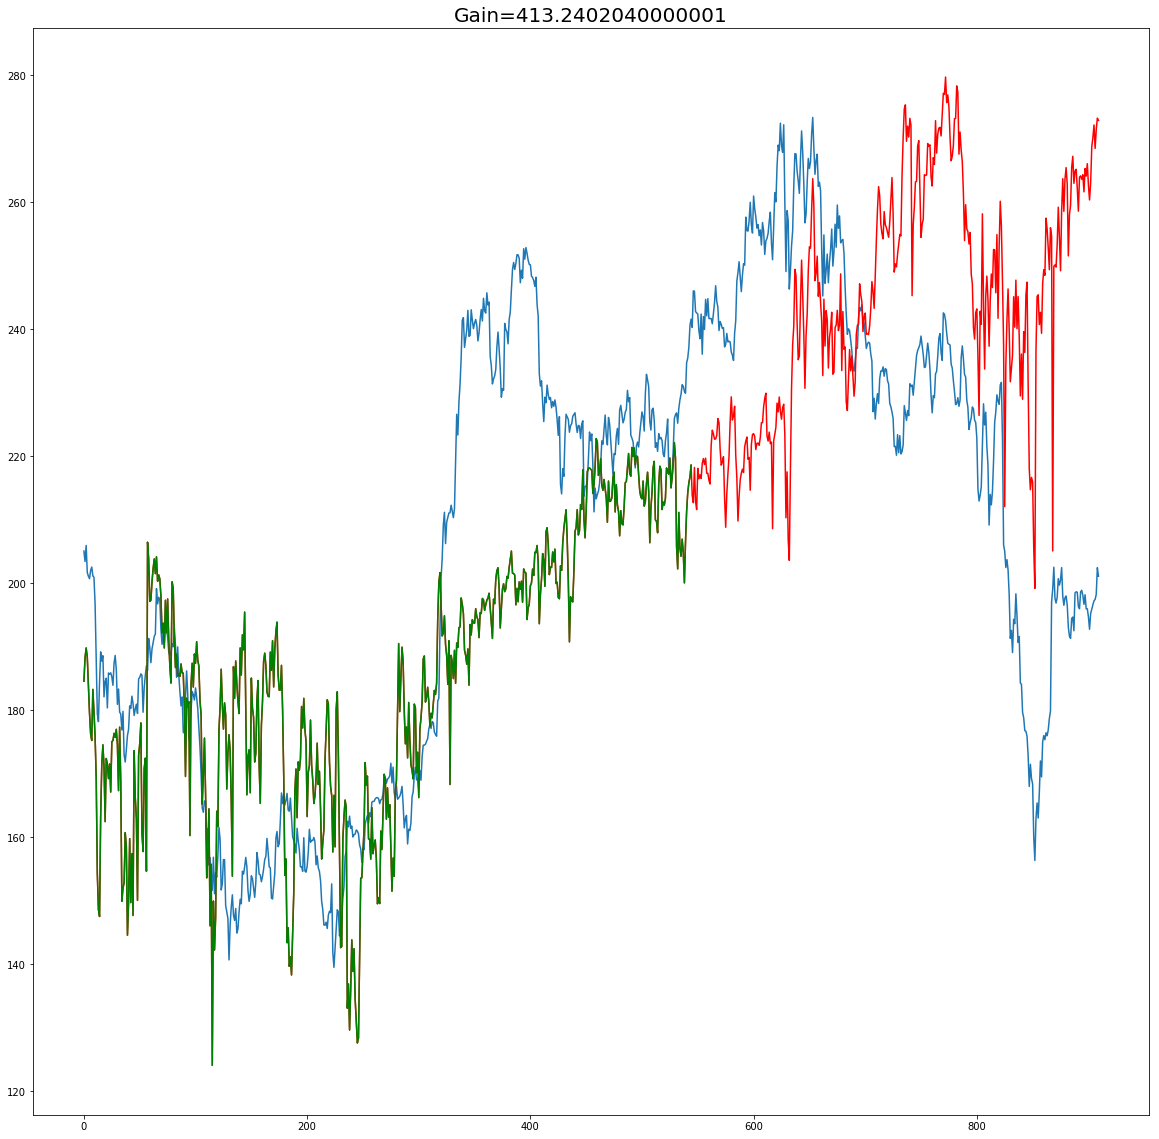

In [ ]:
prices_2=prices_2.rename(columns={'GS_Close':'GS_Close(t)'})
actual=prices_2["GS_Close(t)"][len(prices_2)-len(Xtest_f):]
use=prices_2["GS_Close(t)"][len(prices_2)-len(Xtest_f)-1:]

plt.figure(figsize=(20,20))
plt.plot(prices_2['GS_Close(t)'])

plt.plot(all_predictions_f,'r')
plt.plot(trainPredict_f,'g')
plt.title('Gain={}'.format(np.sum(gainz(testPredict_f,actual,use))),size=20)

# Stacked LSTM with PCA dataset

# Stacked LSTM & passing data as features

In [ ]:
Xtrain_f,ytrain_f,Xtest_f,ytest_f,scaler_x_f,scaler_y_f=transform_features(prices_2)

model_lstm = tensorflow.keras.models.Sequential()
model_lstm.add(layers.LSTM(50, input_shape=(Xtrain_f.shape[1], Xtrain_f.shape[2]),return_sequences=True))
model_lstm.add(layers.LSTM(30, input_shape=(Xtrain_f.shape[1], Xtrain_f.shape[2])))
model_lstm.add(layers.Dense(1))
opt=tensorflow.keras.optimizers.Adam(lr=0.01,epsilon=None,decay=0)
model_lstm.compile(loss='mse', optimizer=opt)
earlyStopping =EarlyStopping(monitor='val_loss', patience=80, verbose=0, mode='min')
mcp_save = ModelCheckpoint('simple_lstm_13.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=70, verbose=1,min_delta=0.00001, mode='min')

model_lstm.fit(Xtrain_f,ytrain_f, epochs=150, batch_size=20, validation_data=(Xtest_f, ytest_f),verbose=1,callbacks=[earlyStopping, mcp_save, reduce_lr_loss])

trainPredict_f=model_lstm.predict(Xtrain_f)
testPredict_f= model_lstm.predict(Xtest_f)

all_predictions_f=[]
trainPredict_f=scaler_y_f.inverse_transform(trainPredict_f)
testPredict_f=scaler_y_f.inverse_transform(testPredict_f)
all_predictions_f=np.append(trainPredict_f,testPredict_f)


Train on 545 samples, validate on 365 samples
Epoch 1/150
545/545 [==============================] - 50s 92ms/step - loss: 0.1240 - val_loss: 0.0920
Epoch 2/150
545/545 [==============================] - 0s 604us/step - loss: 0.0780 - val_loss: 0.1011
Epoch 3/150
545/545 [==============================] - 1s 1ms/step - loss: 0.0764 - val_loss: 0.0784
Epoch 4/150
545/545 [==============================] - 1s 1ms/step - loss: 0.0755 - val_loss: 0.0748
Epoch 5/150
545/545 [==============================] - 0s 910us/step - loss: 0.0627 - val_loss: 0.1335
Epoch 6/150
545/545 [==============================] - 0s 744us/step - loss: 0.0577 - val_loss: 0.2474
Epoch 7/150
545/545 [==============================] - 0s 678us/step - loss: 0.0583 - val_loss: 0.1879
Epoch 8/150
545/545 [==============================] - 0s 694us/step - loss: 0.0534 - val_loss: 0.2432
Epoch 9/150
545/545 [==============================] - 0s 705us/step - loss: 0.0565 - val_loss: 0.1497
Epoch 10/150
545/545 [=========

Text(0.5, 1.0, 'Gain=122.4001780000001')

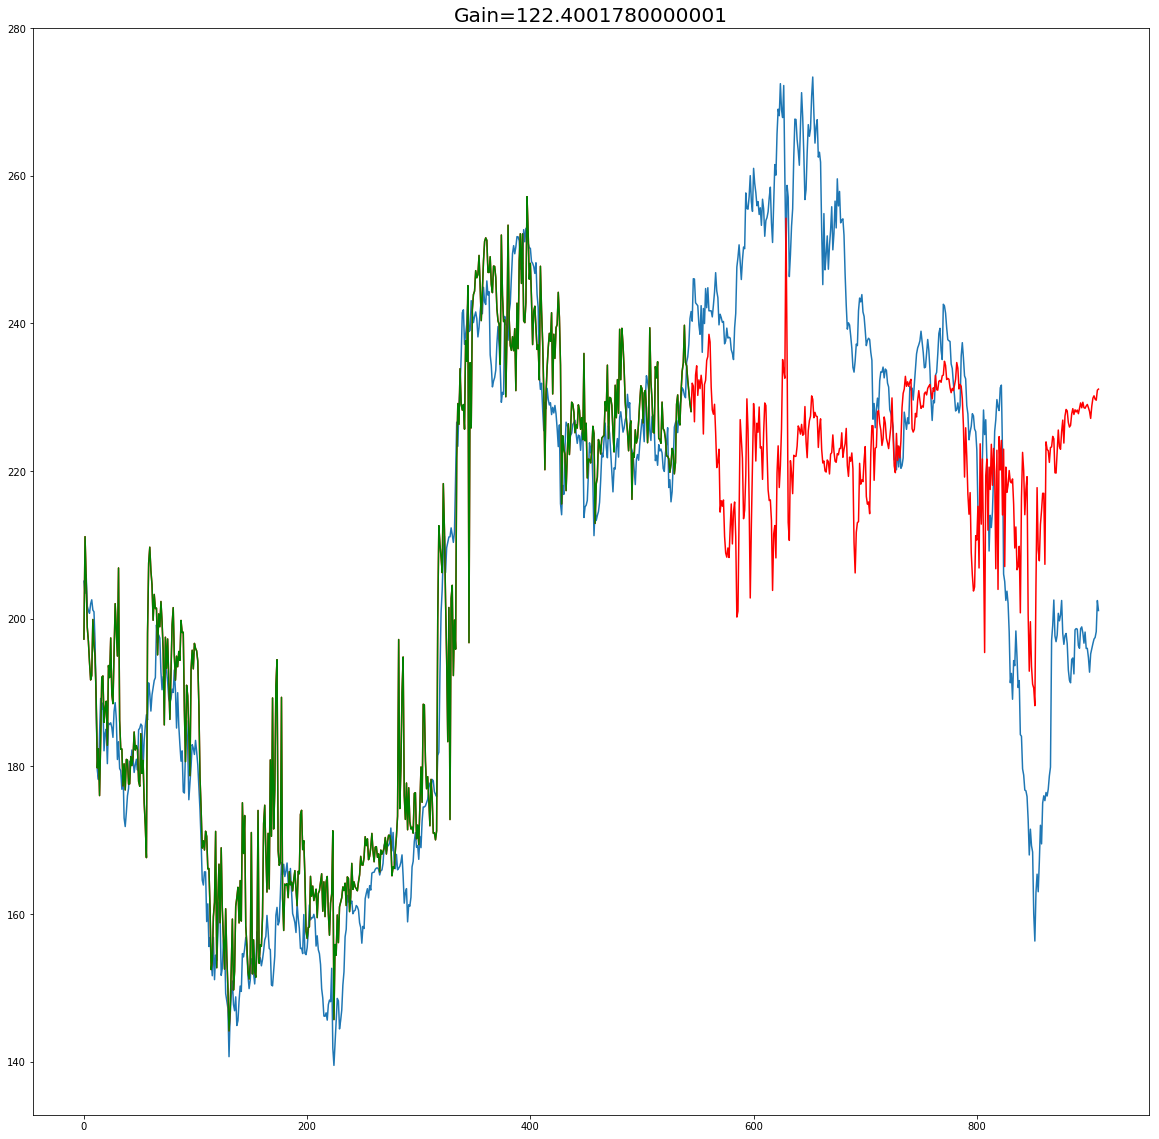

In [ ]:
prices_2=prices_2.rename(columns={'GS_Close':'GS_Close(t)'})
actual=prices_2["GS_Close(t)"][len(prices_2)-len(Xtest_f):]
use=prices_2["GS_Close(t)"][len(prices_2)-len(Xtest_f)-1:]

plt.figure(figsize=(20,20))
plt.plot(prices_2['GS_Close(t)'])

plt.plot(all_predictions_f,'r')
plt.plot(trainPredict_f,'g')
plt.title('Gain={}'.format(np.sum(gainz(testPredict_f,actual,use))),size=20)

# Stacked LSTM & passing data as timesteps

In [ ]:
Xtrain_t,ytrain_t,Xtest_t,ytest_t,scaler_x_t,scaler_y_t=transform_features(prices_2)

model_lstm = tensorflow.keras.models.Sequential()
model_lstm.add(layers.LSTM(50, input_shape=(Xtrain_t.shape[1], Xtrain_t.shape[2]),return_sequences=True))
model_lstm.add(layers.LSTM(30, input_shape=(Xtrain_t.shape[1], Xtrain_t.shape[2])))
model_lstm.add(layers.Dense(1))
opt=tensorflow.keras.optimizers.Adam(lr=0.01,epsilon=None,decay=0)
model_lstm.compile(loss='mse', optimizer=opt)
earlyStopping =EarlyStopping(monitor='val_loss', patience=50, verbose=0, mode='min')
mcp_save = ModelCheckpoint('simple_lstm_13.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=70, verbose=1,min_delta=0.00001, mode='min')

model_lstm.fit(Xtrain_t,ytrain_t, epochs=150, batch_size=20, validation_data=(Xtest_t, ytest_t),verbose=1,callbacks=[earlyStopping, mcp_save, reduce_lr_loss])

trainPredict_t=model_lstm.predict(Xtrain_t)
testPredict_t= model_lstm.predict(Xtest_t)

all_predictions_t=[]
trainPredict_t=scaler_y_t.inverse_transform(trainPredict_t)
testPredict_t=scaler_y_t.inverse_transform(testPredict_t)
all_predictions_t=np.append(trainPredict_t,testPredict_t)


Train on 545 samples, validate on 365 samples
Epoch 1/150
545/545 [==============================] - 56s 103ms/step - loss: 0.1189 - val_loss: 0.1263
Epoch 2/150
545/545 [==============================] - 1s 1ms/step - loss: 0.0779 - val_loss: 0.0969
Epoch 3/150
545/545 [==============================] - 1s 1ms/step - loss: 0.0713 - val_loss: 0.0767
Epoch 4/150
545/545 [==============================] - 0s 842us/step - loss: 0.0688 - val_loss: 0.0883
Epoch 5/150
545/545 [==============================] - 0s 853us/step - loss: 0.0598 - val_loss: 0.1834
Epoch 6/150
545/545 [==============================] - 0s 842us/step - loss: 0.0563 - val_loss: 0.3590
Epoch 7/150
545/545 [==============================] - 0s 852us/step - loss: 0.0590 - val_loss: 0.1722
Epoch 8/150
545/545 [==============================] - 0s 820us/step - loss: 0.0537 - val_loss: 0.2772
Epoch 9/150
545/545 [==============================] - 1s 1ms/step - loss: 0.0562 - val_loss: 0.1208
Epoch 10/150
545/545 [==========

Text(0.5, 1.0, 'Gain=-7.279849999999669')

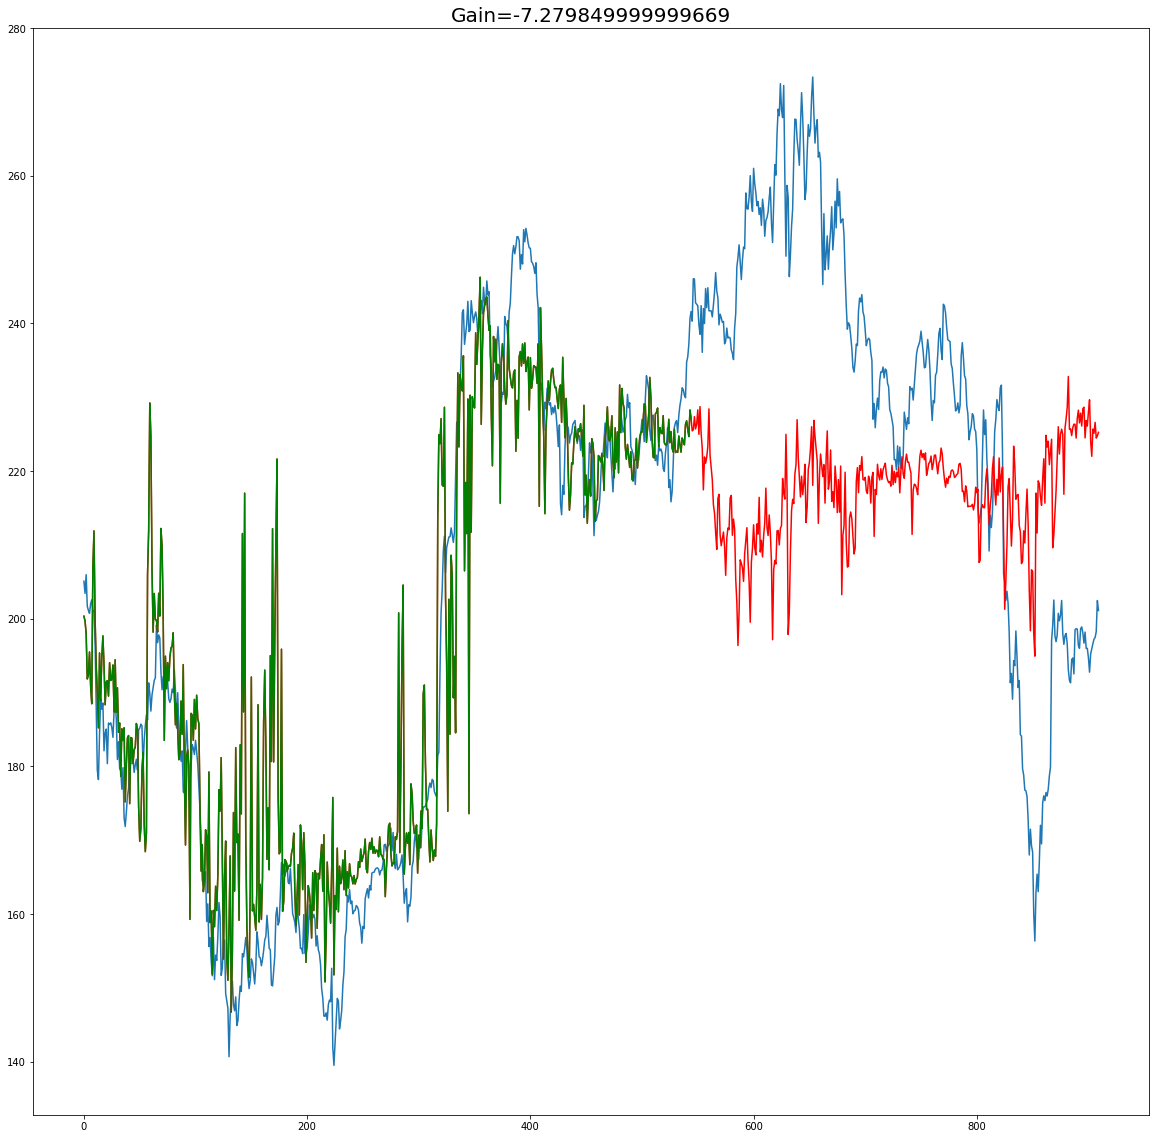

In [ ]:
prices_2=prices_2.rename(columns={'GS_Close':'GS_Close(t)'})
actual=prices_2["GS_Close(t)"][len(prices_2)-len(Xtest_f):]
use=prices_2["GS_Close(t)"][len(prices_2)-len(Xtest_f)-1:]

plt.figure(figsize=(20,20))
plt.plot(prices_2['GS_Close(t)'])

plt.plot(all_predictions_t,'r')
plt.plot(trainPredict_t,'g')
plt.title('Gain={}'.format(np.sum(gainz(testPredict_t,actual,use))),size=20)

# Stacked LSTM with memory between batches

In [ ]:
Xtrain_f,ytrain_f,Xtest_f,ytest_f,scaler_x_f,scaler_y_f=transform_features(prices_2)

model_lstm = tensorflow.keras.models.Sequential()
model_lstm.add(layers.LSTM(50, input_shape=(Xtrain_f.shape[1], Xtrain_f.shape[2]),return_sequences=True))
model_lstm.add(layers.LSTM(30, input_shape=(Xtrain_f.shape[1], Xtrain_f.shape[2])))
model_lstm.add(layers.Dense(1))
opt=tensorflow.keras.optimizers.Adam(lr=0.01,epsilon=None,decay=0)
model_lstm.compile(loss='mse', optimizer=opt)
for i in range(200):
    model_lstm.fit(Xtrain_f,ytrain_f, epochs=1, batch_size=20, validation_data=(Xtest_f,ytest_f),verbose=1,shuffle=False)
    model_lstm.reset_states()
    
trainPredict_mem=model_lstm.predict(Xtrain_f)
model_lstm.reset_states()
testPredict_mem= model_lstm.predict(Xtest_f)

all_predictions_mem=[]
trainPredict_mem=scaler_y_f.inverse_transform(trainPredict_mem)
testPredict_mem=scaler_y_f.inverse_transform(testPredict_mem)
all_predictions_mem=np.append(trainPredict_mem,testPredict_mem)


Train on 545 samples, validate on 365 samples
Epoch 1/1
545/545 [==============================] - 34s 62ms/step - loss: 0.1413 - val_loss: 0.1130
Train on 545 samples, validate on 365 samples
Epoch 1/1
545/545 [==============================] - 1s 1ms/step - loss: 0.2390 - val_loss: 0.2445
Train on 545 samples, validate on 365 samples
Epoch 1/1
545/545 [==============================] - 1s 1ms/step - loss: 0.1096 - val_loss: 0.1371
Train on 545 samples, validate on 365 samples
Epoch 1/1
545/545 [==============================] - 1s 1ms/step - loss: 0.1223 - val_loss: 0.1608
Train on 545 samples, validate on 365 samples
Epoch 1/1
545/545 [==============================] - 1s 1ms/step - loss: 0.1047 - val_loss: 0.1461
Train on 545 samples, validate on 365 samples
Epoch 1/1
545/545 [==============================] - 1s 1ms/step - loss: 0.1072 - val_loss: 0.1477
Train on 545 samples, validate on 365 samples
Epoch 1/1
545/545 [==============================] - 1s 1ms/step - loss: 0.1046 - 

Train on 545 samples, validate on 365 samples
Epoch 1/1
545/545 [==============================] - 0s 864us/step - loss: 0.0937 - val_loss: 0.1301
Train on 545 samples, validate on 365 samples
Epoch 1/1
545/545 [==============================] - 1s 948us/step - loss: 0.0936 - val_loss: 0.1291
Train on 545 samples, validate on 365 samples
Epoch 1/1
545/545 [==============================] - 1s 937us/step - loss: 0.0933 - val_loss: 0.1293
Train on 545 samples, validate on 365 samples
Epoch 1/1
545/545 [==============================] - 1s 918us/step - loss: 0.0936 - val_loss: 0.1279
Train on 545 samples, validate on 365 samples
Epoch 1/1
545/545 [==============================] - 1s 951us/step - loss: 0.0930 - val_loss: 0.1297
Train on 545 samples, validate on 365 samples
Epoch 1/1
545/545 [==============================] - 1s 939us/step - loss: 0.0954 - val_loss: 0.1239
Train on 545 samples, validate on 365 samples
Epoch 1/1
545/545 [==============================] - 1s 933us/step - los

545/545 [==============================] - 1s 1ms/step - loss: 0.0324 - val_loss: 0.1295
Train on 545 samples, validate on 365 samples
Epoch 1/1
545/545 [==============================] - 1s 950us/step - loss: 0.0324 - val_loss: 0.1289
Train on 545 samples, validate on 365 samples
Epoch 1/1
545/545 [==============================] - 1s 980us/step - loss: 0.0322 - val_loss: 0.1263
Train on 545 samples, validate on 365 samples
Epoch 1/1
545/545 [==============================] - 1s 999us/step - loss: 0.0322 - val_loss: 0.1265
Train on 545 samples, validate on 365 samples
Epoch 1/1
545/545 [==============================] - 1s 951us/step - loss: 0.0320 - val_loss: 0.1271
Train on 545 samples, validate on 365 samples
Epoch 1/1
545/545 [==============================] - 1s 939us/step - loss: 0.0322 - val_loss: 0.1261
Train on 545 samples, validate on 365 samples
Epoch 1/1
545/545 [==============================] - 1s 948us/step - loss: 0.0319 - val_loss: 0.1242
Train on 545 samples, validat

Text(0.5, 1.0, 'Gain=-33.279787999999826')

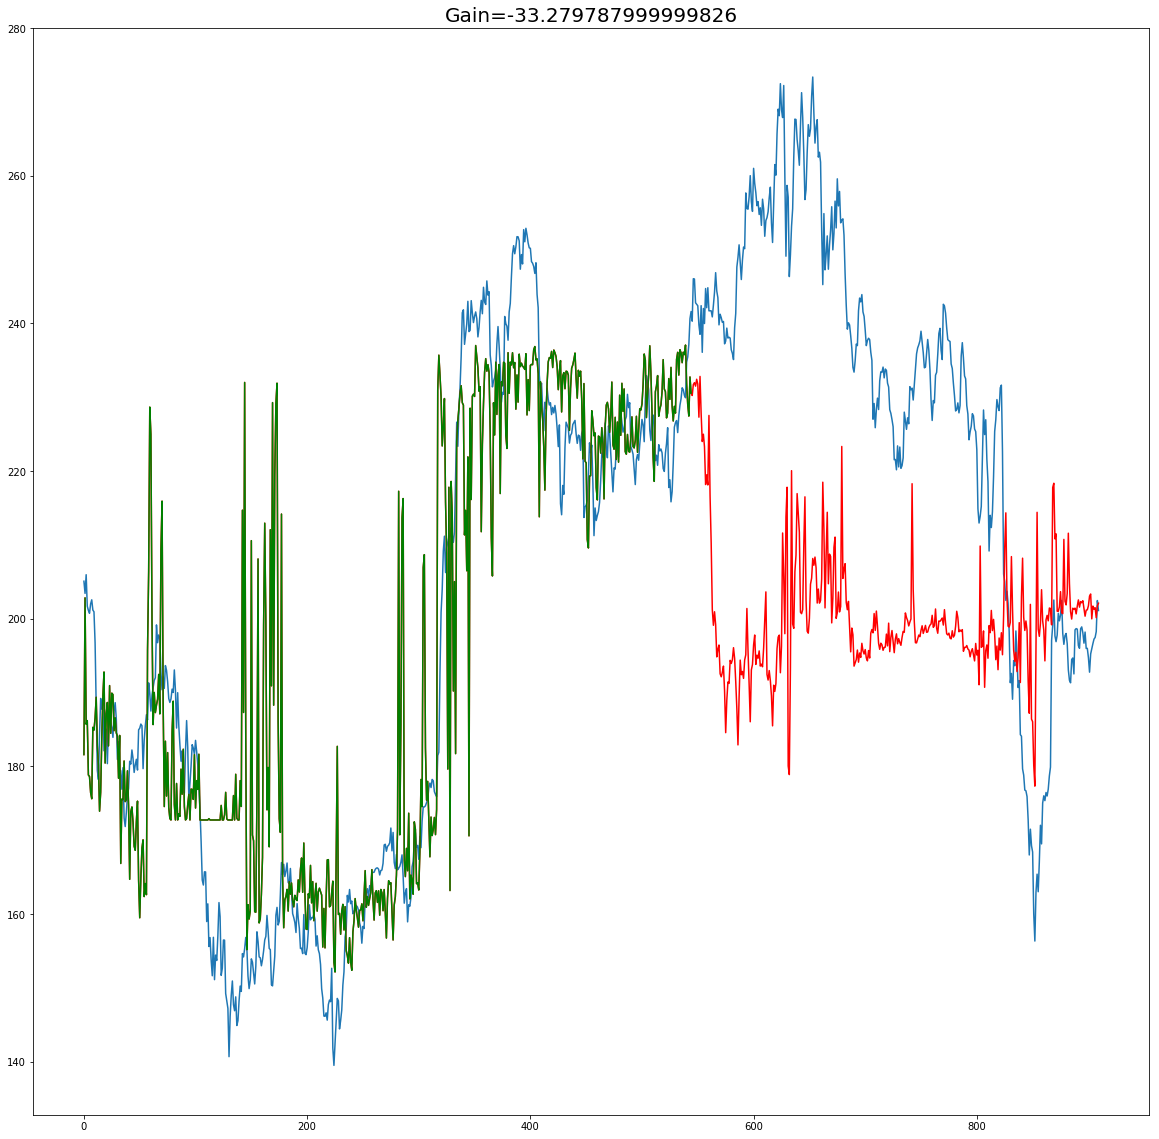

In [ ]:
prices_2=prices_2.rename(columns={'GS_Close':'GS_Close(t)'})

actual=prices_2["GS_Close(t)"][len(prices_2)-len(Xtest_f):]
use=prices_2["GS_Close(t)"][len(prices_2)-len(Xtest_f)-1:]

plt.figure(figsize=(20,20))
plt.plot(prices_2['GS_Close(t)'])

plt.plot(all_predictions_mem,'r')
plt.plot(trainPredict_mem,'g')
plt.title('Gain={}'.format(np.sum(gainz(testPredict_mem,actual,use))),size=20)

### Adding Dropout

In [ ]:
Xtrain_f,ytrain_f,Xtest_f,ytest_f,scaler_x_f,scaler_y_f=transform_features(prices_2)

model_lstm = tensorflow.keras.models.Sequential()
model_lstm.add(layers.LSTM(50, input_shape=(Xtrain_f.shape[1], Xtrain_f.shape[2]),return_sequences=True))
model_lstm.add(layers.Dropout(0.2))
model_lstm.add(layers.LSTM(30, input_shape=(Xtrain_f.shape[1], Xtrain_f.shape[2])))
model_lstm.add(layers.Dense(1))
opt=tensorflow.keras.optimizers.Adam(lr=0.01,epsilon=None,decay=0)
model_lstm.compile(loss='mse', optimizer=opt)
earlyStopping =EarlyStopping(monitor='val_loss', patience=80, verbose=0, mode='min')
mcp_save = ModelCheckpoint('simple_lstm_15.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=70, verbose=1,min_delta=0.00001, mode='min')

model_lstm.fit(Xtrain_f,ytrain_f, epochs=150, batch_size=20, validation_data=(Xtest_f, ytest_f),verbose=1,callbacks=[earlyStopping, mcp_save, reduce_lr_loss])

trainPredict_f=model_lstm.predict(Xtrain_f)
testPredict_f= model_lstm.predict(Xtest_f)

all_predictions_f=[]
trainPredict_f=scaler_y_f.inverse_transform(trainPredict_f)
testPredict_f=scaler_y_f.inverse_transform(testPredict_f)
all_predictions_f=np.append(trainPredict_f,testPredict_f)


Train on 545 samples, validate on 365 samples
Epoch 1/150
545/545 [==============================] - 91s 166ms/step - loss: 0.1191 - val_loss: 0.0871
Epoch 2/150
545/545 [==============================] - 1s 2ms/step - loss: 0.0793 - val_loss: 0.1052
Epoch 3/150
545/545 [==============================] - 1s 2ms/step - loss: 0.0699 - val_loss: 0.0826
Epoch 4/150
545/545 [==============================] - 1s 2ms/step - loss: 0.0729 - val_loss: 0.1231
Epoch 5/150
545/545 [==============================] - 1s 2ms/step - loss: 0.0685 - val_loss: 0.1066
Epoch 6/150
545/545 [==============================] - 1s 2ms/step - loss: 0.0586 - val_loss: 0.1373
Epoch 7/150
545/545 [==============================] - 1s 2ms/step - loss: 0.0594 - val_loss: 0.1772
Epoch 8/150
545/545 [==============================] - 1s 1ms/step - loss: 0.0564 - val_loss: 0.0977
Epoch 9/150
545/545 [==============================] - 1s 1ms/step - loss: 0.0618 - val_loss: 0.1442
Epoch 10/150
545/545 [====================

Text(0.5, 1.0, 'Gain=-184.7399860000001')

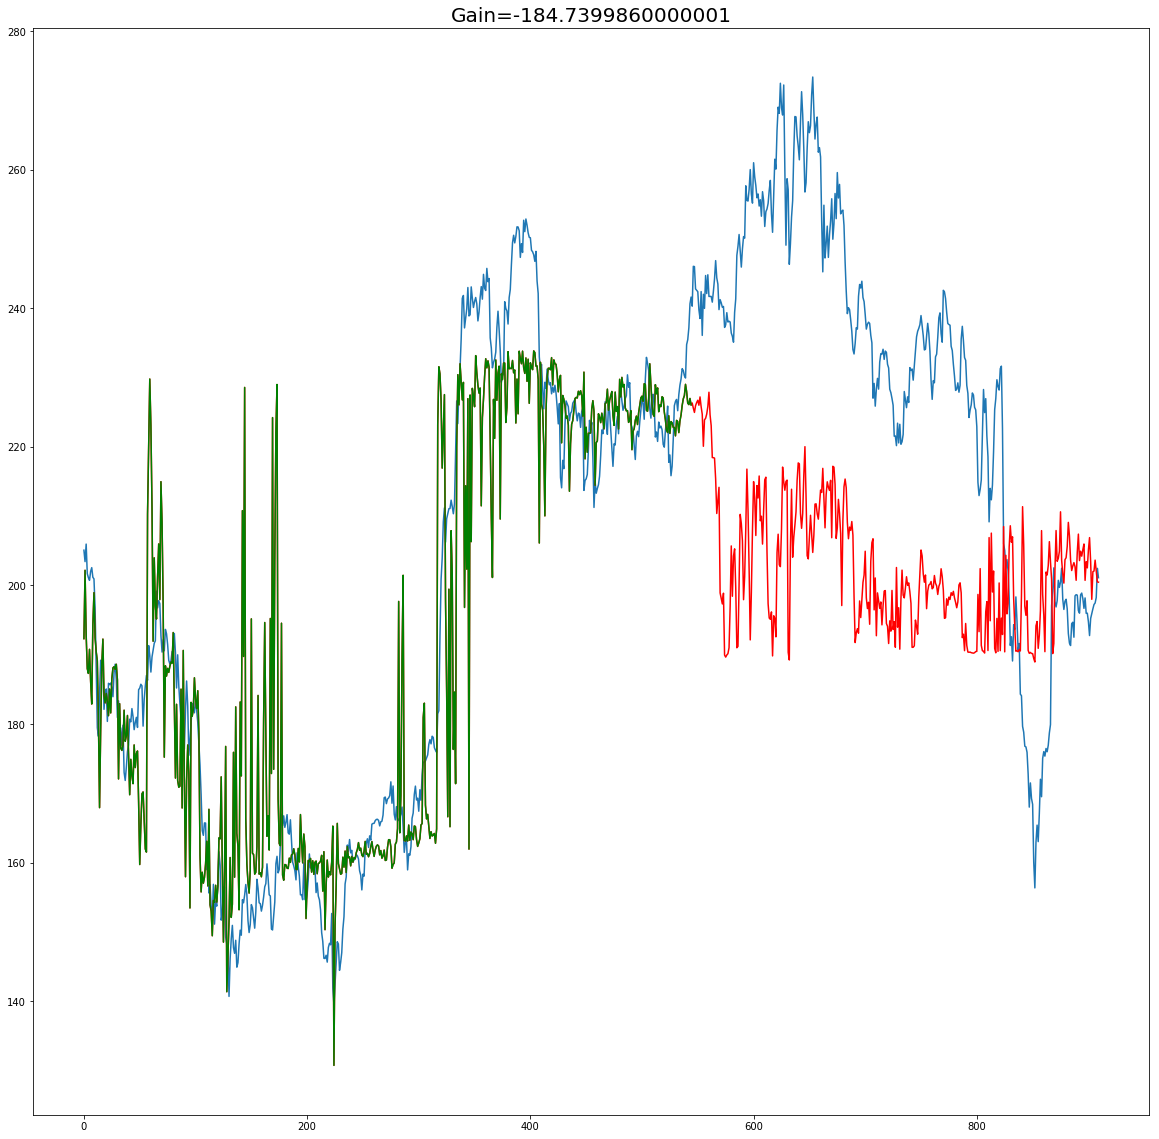

In [ ]:
prices_2=prices_2.rename(columns={'GS_Close':'GS_Close(t)'})
actual=prices_2["GS_Close(t)"][len(prices_2)-len(Xtest_f):]
use=prices_2["GS_Close(t)"][len(prices_2)-len(Xtest_f)-1:]

plt.figure(figsize=(20,20))
plt.plot(prices_2['GS_Close(t)'])

plt.plot(all_predictions_f,'r')
plt.plot(trainPredict_f,'g')
plt.title('Gain={}'.format(np.sum(gainz(testPredict_f,actual,use))),size=20)